#AI-Driven Real Estate Investment Advisor: Predicting ROI, Price Trends & Property Desirability


=======================
# BUSINESS GOAL
=======================


- Identify properties to buy such that **HOA + Mortgage < Rent**, maximizing **ROI now** and in the **future** (predict house prices in 1, 2, and 5 years).  
- Classify properties into **Least**, **More**, and **Most Desirable** for investors.

===============================================
# DATA NARATIVE AND HYPOTHESIS
================================================

**Business Case:** Help an investor choose properties where **(HOA + Mortgage) < Rent** and long‑term **appreciation** is strong.

**Hypotheses to test:**  
1. **H1 (Cashflow):** Properties in regions with higher rents (ZORI) and reasonable mortgage + HOA produce **positive ROI** now.  
2. **H2 (Neighborhood Quality):** Areas with **better school quality** sustain **higher rents** and **lower vacancy**, improving ROI and desirability.  
3. **H3 (Appreciation):** Regions with stronger **home value growth** (ZHVI) deliver better **future returns**.  
4. **H4 (Combined):** Adding education + market latent variables **improves model performance** (classification & regression) vs base data only.


## Setup & Libraries

In [ ]:
# --- Colab setup: installs & folders ---
!pip -q install gdown pandas openpyxl

from pathlib import Path
from typing import Optional
import os, re, json, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

=======================
# DATA PREPARATION
=======================


## 3a) Data Prep — Load Base Dataset (Dataset 1)
We use the professor-provided dataset as **Dataset 1**. We extract ZIPs and clean numeric fields.

Downloads Dataset 1 (Real Estate) from Google Drive.


In [ ]:
# --- Download Dataset 1 & 2 from Google Drive using gdown ---
import os
import gdown

# Dataset 1 (Real Estate)
ds1_id = "11WyHlKRJJ0UoJa-V2pJKg3aZ-9ZmxwGB"
ds1_out = "/content/Dataset1.csv"
if not os.path.exists(ds1_out):
    print("Downloading Dataset 1 (Real Estate)...")
    gdown.download(id=ds1_id, output=ds1_out, quiet=False)
else:
    print("Dataset 1 already exists:", ds1_out)

Downloading...
From: https://drive.google.com/uc?id=11WyHlKRJJ0UoJa-V2pJKg3aZ-9ZmxwGB
To: /content/Dataset1.csv
100%|██████████| 1.28M/1.28M [00:00<00:00, 52.3MB/s]


Preprocess the dataset

In [ ]:
# --- Helper functions ---
STATE_ABBREV_MAP = {
    'ALABAMA':'AL','ALASKA':'AK','ARIZONA':'AZ','ARKANSAS':'AR','CALIFORNIA':'CA','COLORADO':'CO','CONNECTICUT':'CT',
    'DELAWARE':'DE','DISTRICT OF COLUMBIA':'DC','FLORIDA':'FL','GEORGIA':'GA','HAWAII':'HI','IDAHO':'ID','ILLINOIS':'IL',
    'INDIANA':'IN','IOWA':'IA','KANSAS':'KS','KENTUCKY':'KY','LOUISIANA':'LA','MAINE':'ME','MARYLAND':'MD','MASSACHUSETTS':'MA',
    'MICHIGAN':'MI','MINNESOTA':'MN','MISSISSIPPI':'MS','MISSOURI':'MO','MONTANA':'MT','NEBRASKA':'NE','NEVADA':'NV','NEW HAMPSHIRE':'NH',
    'NEW JERSEY':'NJ','NEW MEXICO':'NM','NEW YORK':'NY','NORTH CAROLINA':'NC','NORTH DAKOTA':'ND','OHIO':'OH','OKLAHOMA':'OK',
    'OREGON':'OR','PENNSYLVANIA':'PA','RHODE ISLAND':'RI','SOUTH CAROLINA':'SC','SOUTH DAKOTA':'SD','TENNESSEE':'TN',
    'TEXAS':'TX','UTAH':'UT','VERMONT':'VT','VIRGINIA':'VA','WASHINGTON':'WA','WEST VIRGINIA':'WV','WISCONSIN':'WI','WYOMING':'WY',
    'PUERTO RICO':'PR'
}
STATE_ABBREV_SET = set(STATE_ABBREV_MAP.values())

def extract_city_state_zip(address: str):
    if not isinstance(address, str) or not address.strip():
        return (None, None, None)
    import re
    zip_match   = re.search(r'(\d{5})(?:-\d{4})?', address)
    zipcode     = zip_match.group(1) if zip_match else None
    state_match = re.search(r',\s*([A-Z]{2})\s*\d{5}', address)
    state_abbrev = state_match.group(1) if state_match else None
    if not state_abbrev:
        m = re.search(r',\s*([A-Z]{2})\s*$', address)
        if m: state_abbrev = m.group(1)
    city = None
    if state_abbrev and zipcode:
        mcity = re.search(r',\s*([^,]+?),\s*' + state_abbrev + r'\s*' + zipcode, address)
        city = mcity.group(1).strip() if mcity else None
    if not city and state_abbrev:
        mcity2 = re.search(r',\s*([^,]+?),\s*' + state_abbrev + r'\b', address)
        city = mcity2.group(1).strip() if mcity2 else city
    return (city, state_abbrev, zipcode)

def to_float_safe(x) -> Optional[float]:
    if pd.isna(x):
        return None
    if isinstance(x, (int, float)):
        return float(x)
    s = str(x).replace(',', '')
    import re
    s = re.sub(r'[^0-9.\-]', '', s)
    try:
        return float(s) if s not in ('', '-') else None
    except:
        return None

def monthly_mortgage_payment(principal, annual_rate=0.065, years=30):
    if principal is None or principal <= 0:
        return None
    r = annual_rate / 12.0
    n = years * 12
    if r == 0:
        return principal / n
    return principal * (r * (1 + r)**n) / ((1 + r)**n - 1)

def estimate_monthly_piti(price: Optional[float], down_payment_pct=0.20, annual_rate=0.065,
                          years=30, property_tax_rate=0.0125, insurance_rate=0.004):
    if price is None:
        return (None, None, None, None)
    loan = price * (1 - down_payment_pct)
    pi   = monthly_mortgage_payment(loan, annual_rate=annual_rate, years=years)
    tax  = price * property_tax_rate / 12.0
    ins  = price * insurance_rate / 12.0
    piti = (pi or 0) + tax + ins
    return (loan, pi, tax + ins, piti)

def bucket_desirability(margin):
    if pd.isna(margin): return None
    if margin >= 1000:  return 'most'
    if margin >= 0:     return 'more'
    return 'least'


Clean and save preprocessed dataset 1

In [ ]:
# --- Clean Dataset 1 (Real Estate) ---
DS1_CSV  = Path('/content/Dataset1.csv')

def load_dataset1():
    if DS1_CSV.exists():
        return pd.read_csv(DS1_CSV)

df1 = load_dataset1()
df1.columns = [c.strip().lower().replace(' ', '_') for c in df1.columns]

for col in ['price','zestimate','rent_zestimate','bedrooms','bathrooms','latitude','longitude','days_on_zillow']:
    if col in df1.columns:
        df1[col] = df1[col].apply(to_float_safe)
for szcol in ['area','land_area']:
    if szcol in df1.columns:
        df1[szcol+'_sqft'] = df1[szcol].apply(to_float_safe)

if 'address' in df1.columns:
    parsed = df1['address'].apply(extract_city_state_zip)
    df1[['city','state','zip']] = pd.DataFrame(parsed.tolist(), index=df1.index)

subset_cols = [c for c in ['property_id','listing_url','address'] if c in df1.columns]
if subset_cols:
    df1 = df1.drop_duplicates(subset=subset_cols)

if 'price' in df1.columns:
    loans, pis, ti, piti = [], [], [], []
    for p in df1['price'].tolist():
        loan, pi, taxins, total = estimate_monthly_piti(p)
        loans.append(loan); pis.append(pi); ti.append(taxins); piti.append(total)
    df1['loan_amount']     = loans
    df1['monthly_pi']      = pis
    df1['monthly_tax_ins'] = ti
    df1['monthly_piti']    = piti

if 'hoa' in df1.columns:
    df1['hoa'] = pd.to_numeric(df1['hoa'], errors='coerce').fillna(0)
else:
    df1['hoa'] = 0.0

# Compute ROI margin and desirability
if 'rent_zestimate' in df1.columns:
    df1['roi_margin_monthly'] = df1['rent_zestimate'] - (df1['monthly_piti'].fillna(0) + df1['hoa'])
    df1['desirability_bucket_init'] = df1['roi_margin_monthly'].apply(bucket_desirability)

clean1_path = Path('/content/dataset1_cleaned.csv')
df1.to_csv(clean1_path, index=False)
print('Saved cleaned Dataset 1 ->', clean1_path)
df1.head()


Saved cleaned Dataset 1 -> /content/dataset1_cleaned.csv


,rank,property_id,address,latitude,longitude,price,currency,bathrooms,bedrooms,area,...,city,state,zip,loan_amount,monthly_pi,monthly_tax_ins,monthly_piti,hoa,roi_margin_monthly,desirability_bucket_init
0,327,17013428,"5228 N Thorn St, San Diego, CA 92105",32.739998,-117.083010,695000.0,USD,1.0,2.0,744 sqft,...,San Diego,CA,92105,556000.0,3514.298211,955.625,4469.923211,0.0,-2117.923211,least
1,434,69302507,"801 S Winchester Blvd APT 2103, San Jose, CA 9...",37.312510,-121.951100,835000.0,USD,2.0,2.0,986 sqft,...,San Jose,CA,95128,668000.0,4222.214397,1148.125,5370.339397,0.0,-2130.339397,least
2,791,443220556,"0 E Hedding St, San Jose, CA 95112",37.353893,-121.902916,899000.0,USD,NaN,NaN,NaN,...,San Jose,CA,95112,719200.0,4545.833225,1236.125,5781.958225,0.0,NaN,None
3,652,2055630092,"1141 Saratoga Ave, San Jose, CA 95129",37.304360,-121.979510,3300000.0,USD,3.0,3.0,1559 sqft,...,San Jose,CA,95129,2640000.0,16686.595820,4537.500,21224.095820,0.0,-16405.095820,least
4,285,140313717,"3526 7th Ave, San Diego, CA 92103",32.741726,-117.158730,4500000.0,USD,5.0,4.0,4934 sqft,...,San Diego,CA,92103,3600000.0,22754.448846,6187.500,28941.948846,0.0,-21483.948846,least


## 3b) Data Prep — Load Education Datase (Dataset 2)

Downloads **Dataset 2** (Education: `states_all.csv`) from Google Drive.

In [ ]:
# Dataset 2 (Education / School Quality)
ds2_id = "1ZrzqoCPqV85hN-KnRcxwpnA5YunSfHi_"
ds2_out = "/content/Dataset2.csv"
if not os.path.exists(ds2_out):
    print("Downloading Dataset 2 (Education)...")
    gdown.download(id=ds2_id, output=ds2_out, quiet=False)
else:
    print("Dataset 2 already exists:", ds2_out)

Downloading...
From: https://drive.google.com/uc?id=1ZrzqoCPqV85hN-KnRcxwpnA5YunSfHi_
To: /content/Dataset2.csv
100%|██████████| 294k/294k [00:00<00:00, 12.8MB/s]


Preprocess the Dataset 2 and save the cleaned Dataset 2

In [ ]:
# --- Clean Dataset 2 (Education: states_all.csv) ---
EDU_PATH = Path('/content/Dataset2.csv')
edu_state = None
if EDU_PATH.exists():
    edu = pd.read_csv(EDU_PATH, low_memory=False)
    edu.columns = [c.strip().upper() for c in edu.columns]
    edu = edu[edu['STATE'].notna()].copy()
    edu = edu[~edu['STATE'].str.upper().eq('UNITED STATES')]
    edu['YEAR'] = pd.to_numeric(edu['YEAR'], errors='coerce')
    edu_latest = edu.sort_values(['STATE','YEAR']).groupby('STATE').tail(1).copy()

    candidate_cols = [
        'ENROLL','TOTAL_EXPENDITURE','EXPENDITURE_PER_STUDENT',
        'AVG_MATH_8_SCORE','AVG_READING_8_SCORE','AVG_MATH_4_SCORE','AVG_READING_4_SCORE',
        'GRADES_ALL_G','AVG_TEACHER_SALARY'
    ]
    present = [c for c in candidate_cols if c in edu_latest.columns]
    edu_state = edu_latest[['STATE','YEAR'] + present].copy()

    if 'TOTAL_EXPENDITURE' in edu_state.columns and 'ENROLL' in edu_state.columns:
        edu_state['EXP_PER_STUDENT_DERIVED'] = pd.to_numeric(edu_state['TOTAL_EXPENDITURE'], errors='coerce') / pd.to_numeric(edu_state['ENROLL'], errors='coerce')

    edu_state['STATE_ABBR'] = edu_state['STATE'].str.upper().map(STATE_ABBREV_MAP).fillna(edu_state['STATE'].str.upper())
    edu_state['STATE_ABBR'] = edu_state['STATE_ABBR'].apply(lambda s: s if isinstance(s, str) and s in STATE_ABBREV_SET else None)
    edu_state = edu_state[edu_state['STATE_ABBR'].notna()].copy()

    edu_state_path = Path('/content/dataset2_cleaned.csv')
    edu_state.to_csv(edu_state_path, index=False)
    print('Saved cleaned Dataset 2 ->', edu_state_path)
    edu_state.head()
else:
    raise FileNotFoundError('Education file not found at /content/Dataset2.csv')


Saved cleaned Dataset 2 -> /content/dataset2_cleaned.csv


## 3c) Data Prep — Dataset 3: Latent Variables (Zillow ZHVI & ZORI)

Objective:
The goal of Dataset 3 is to introduce latent market features that capture regional housing and rental trends. These variables represent the underlying economic conditions that influence an investor’s return potential, such as how fast property values and rents are increasing in each ZIP code.

Data Sources:

Zillow Home Value Index (ZHVI) — provides median home values over time for each ZIP code.

Zillow Observed Rent Index (ZORI) — provides typical rental prices for the same ZIP codes.
Both datasets were downloaded from the Zillow Research Portal as wide CSV files, each containing a RegionName (ZIP) column and monthly columns labeled YYYY-MM (e.g., 2019-01, 2019-02, …).

Loading the datasets from Gdrive

In [ ]:
!gdown --fuzzy "https://drive.google.com/file/d/1Stb_A81bYpk9VUApwdqInM3X-37yAT6d/view?usp=sharing" -O Dataset3_ZHVI.csv
!gdown --fuzzy "https://drive.google.com/file/d/1uxKa3yanlpnN1lIuDhcwUQ8TIkZ4hAdX/view?usp=sharing" -O Dataset3_ZORI.csv

Downloading...
From: https://drive.google.com/uc?id=1Stb_A81bYpk9VUApwdqInM3X-37yAT6d
To: /content/Dataset3_ZHVI.csv
100% 2.03M/2.03M [00:00<00:00, 25.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uxKa3yanlpnN1lIuDhcwUQ8TIkZ4hAdX
To: /content/Dataset3_ZORI.csv
100% 8.62M/8.62M [00:00<00:00, 85.1MB/s]



Imports & File Paths


In [ ]:
import pandas as pd
import numpy as np
import re

# Replace these with your actual files (wide time-series, monthly columns YYYY-MM)
ZILLOW_ZHVI_CSV = "/content/Dataset3_ZHVI.csv"   # Zillow Home Value Index
ZILLOW_ZORI_CSV = "/content/Dataset3_ZORI.csv"   # Zillow Observed Rent Index
OUTPUT_CSV = "/content/Dataset3_latent.csv"  # change if desired

Preprocess the Datasets

In [ ]:
# ======================================
# STEP 2: Helper utilities
# ======================================
import pandas as pd
import numpy as np
import re

def _find_id_col(df):
    # Typical candidates in Zillow files
    for cand in ["RegionName", "Zip", "RegionID", "Region", "PostalCode"]:
        if cand in df.columns:
            return cand
    # fallback: try detecting any column that looks like ZIP-ish
    for c in df.columns:
        if "zip" in c.lower() or "postal" in c.lower():
            return c
    raise ValueError("Could not find ZIP/Region identifier column.")

def _standardize_zip(series):
    """Return zero-padded 5-digit ZIP strings; coerce others to NaN."""
    s = series.astype(str).str.extract(r"(\d{5})", expand=False)
    return s.str.zfill(5)


def load_zillow_timeseries(csv_path, id_col="RegionName"):
    """
    Reads Zillow time-series (ZHVI or ZORI) and extracts:
      - latest value (most recent month)
      - one-year growth %
    Returns DataFrame with ZIP, latest, one_year_growth
    """
    df = pd.read_csv(csv_path)
    print(f"Loaded {csv_path} → shape: {df.shape}")

    # Identify monthly columns (YYYY-MM) - This was the original logic from jhfVVDLvRM7h
    date_cols = [c for c in df.columns if re.match(r"\d{4}-\d{2}", str(c))]
    # If no date columns, assume it's a pre-processed file and look for 'latest' and 'one_year_growth' like columns
    if not date_cols:
        print("No YYYY-MM date columns found, assuming pre-processed file.")
        latest_col = None
        growth_col = None
        for c in df.columns:
            if "latest" in c.lower() or "median" in c.lower() or "value" in c.lower() or "rent" in c.lower():
                 latest_col = c
            if "growth" in c.lower() or "change" in c.lower():
                 growth_col = c

        if latest_col is None:
             raise ValueError("Could not find 'latest' or similar value column in the pre-processed file.")

        out = df[[id_col, latest_col]].copy()
        out = out.rename(columns={id_col: "ZIP", latest_col: "latest"})
        out["ZIP"] = _standardize_zip(out["ZIP"])

        if growth_col is not None:
            out["one_year_growth"] = df[growth_col]
        else:
            out["one_year_growth"] = np.nan

        return out[["ZIP", "latest", "one_year_growth"]]


    date_cols = sorted(date_cols)
    latest_col = date_cols[-1]
    one_year_ago_col = date_cols[-13] if len(date_cols) > 12 else None

    # Keep relevant columns
    out = df[[id_col] + date_cols].copy()

    # Compute latest + growth
    out["latest"] = pd.to_numeric(out[latest_col], errors="coerce")
    out["one_year_growth"] = np.nan
    if one_year_ago_col:
        base = pd.to_numeric(out[one_year_ago_col], errors="coerce")
        out["one_year_growth"] = (out["latest"] - base) / base.replace({0: np.nan})


    # Rename RegionName → ZIP
    out = out.rename(columns={id_col: "ZIP"})
    out["ZIP"] = out["ZIP"].astype(str).str.zfill(5)

    return out[["ZIP", "latest", "one_year_growth"]]


def maybe_rescale_home_values(series):
    """
    Heuristic: if median home value is implausibly small (e.g., < 10),
    assume values are in 'hundreds of thousands' and multiply by 100000.
    """
    med = series.dropna().median()
    if pd.notna(med) and med < 10000:
        print("Heuristic rescale applied: multiplying home values by 100000 (values looked too small).")
        return series * 100000.0
    return series

Merging the Zillow Observed Rent Index (ZORI) dataset and Zillow Home Value Forecast (ZHVF)

In [ ]:
MERGED_OUT = "/content/Dataset3.csv" # intermediate merged file

# === Cell 2: Process & Merge (ZHVI + ZORI) ===
zhvi = load_zillow_timeseries(ZILLOW_ZHVI_CSV).rename(columns={
    "latest": "median_home_value_zip",
    "one_year_growth": "home_value_growth_1y"
})
# Rescale if needed (e.g., 2.3 => 230,000)
zhvi["median_home_value_zip"] = maybe_rescale_home_values(zhvi["median_home_value_zip"])

zori = load_zillow_timeseries(ZILLOW_ZORI_CSV).rename(columns={
    "latest": "median_rent_zip",
    "one_year_growth": "rent_growth_1y"
})

zillow_merged = pd.merge(zhvi, zori, on="ZIP", how="outer")
print("\nMerged Zillow dataset shape:", zillow_merged.shape)

# Drop rows where BOTH home value and rent are missing
zillow_merged = zillow_merged.dropna(subset=["median_home_value_zip","median_rent_zip"], how="all")

# Enforce dtypes
for c in ["median_home_value_zip","home_value_growth_1y","median_rent_zip","rent_growth_1y"]:
    zillow_merged[c] = pd.to_numeric(zillow_merged[c], errors="coerce")

print("\nNull counts after merge/cleanup:")
print(zillow_merged.isnull().sum())

# Save intermediate merged file
zillow_merged.to_csv(MERGED_OUT, index=False)
print(f"\nSaved merged Zillow dataset to {MERGED_OUT}")
zillow_merged.head(8)


Loaded /content/Dataset3_ZHVI.csv → shape: (20150, 13)
Heuristic rescale applied: multiplying home values by 100000 (values looked too small).
Loaded /content/Dataset3_ZORI.csv → shape: (7849, 138)

Merged Zillow dataset shape: (20285, 5)

Null counts after merge/cleanup:
ZIP                          0
median_home_value_zip      135
home_value_growth_1y     20285
median_rent_zip          12439
rent_growth_1y           14615
dtype: int64

Saved merged Zillow dataset to /content/Dataset3.csv


,ZIP,median_home_value_zip,home_value_growth_1y,median_rent_zip,rent_growth_1y
0,01001,220000.0,NaN,NaN,NaN
1,01002,170000.0,NaN,2883.115079,0.054827
2,01005,280000.0,NaN,NaN,NaN
3,01007,200000.0,NaN,NaN,NaN
4,01008,230000.0,NaN,NaN,NaN
5,01010,240000.0,NaN,NaN,NaN
6,01011,190000.0,NaN,NaN,NaN
7,01012,180000.0,NaN,NaN,NaN


Save the cleaned dataset 3

In [ ]:
FINAL_OUT  = "/content/dataset3_cleaned.csv"  # final cleaned file

# === Cell 3: Post-clean sanity & Final Save ===
df = pd.read_csv(MERGED_OUT)

# If growth columns are entirely NaN (e.g., not enough months available), fill 0.0 so models run
for c in ["home_value_growth_1y", "rent_growth_1y"]:
    if df[c].isna().all():
        df[c] = 0.0
        print(f"Filled {c} with 0.0 (no 1-year baseline available).")

# Re-check home value scaling (in case Cell 2 was skipped/edited)
if df["median_home_value_zip"].median(skipna=True) < 10:
    df["median_home_value_zip"] = df["median_home_value_zip"] * 100000.0
    print("Rescale applied in Cell 3: home values * 100000.")

# Save final clean dataset
df.to_csv(FINAL_OUT, index=False)
print(f"\nSaved clean Dataset 3 to {FINAL_OUT}")

# Tiny summary
print("\nSummary preview:")
print("Rows:", len(df))
print(df.isnull().sum())
df.head(8)


Filled home_value_growth_1y with 0.0 (no 1-year baseline available).

Saved clean Dataset 3 to /content/dataset3_cleaned.csv

Summary preview:
Rows: 20285
ZIP                          0
median_home_value_zip      135
home_value_growth_1y         0
median_rent_zip          12439
rent_growth_1y           14615
dtype: int64


,ZIP,median_home_value_zip,home_value_growth_1y,median_rent_zip,rent_growth_1y
0,1001,220000.0,0.0,NaN,NaN
1,1002,170000.0,0.0,2883.115079,0.054827
2,1005,280000.0,0.0,NaN,NaN
3,1007,200000.0,0.0,NaN,NaN
4,1008,230000.0,0.0,NaN,NaN
5,1010,240000.0,0.0,NaN,NaN
6,1011,190000.0,0.0,NaN,NaN
7,1012,180000.0,0.0,NaN,NaN


=======================
# AMALGAMATION
=======================


## 3a) **Amalgamation of Dataset1 and Dataset2 — Data Enrichment (Schools / Education Index)**
Goal:
Enhance the base real-estate dataset with education-quality indicators that describe the overall learning environment within each state.
These features help investors understand how school performance may influence housing desirability and long-term value.

Action:
Use the U.S. Education Statistics (states_all.csv) dataset from the Department of Education (via Kaggle / Google Drive).
From this dataset, extract each state’s most recent year (2019) and retain key academic metrics such as:

- AVG_MATH_8_SCORE
- AVG_READING_8_SCORE
- AVG_MATH_4_SCORE
- AVG_READING_4_SCORE

Process:

- Standardize state names and abbreviations.
- Keep the latest available record for each state.
- Merge these state-level indicators with the base real-estate dataset on the state ↔ STATE_ABBR key.

Result:
Every property now carries its state’s average academic performance scores, forming a state-level education index.
This enrichment captures how broader educational quality correlates with property demand and perceived neighborhood desirability.


In [ ]:
# --- Amalgamate by state & report enrichment count ---
df1['state_abbr'] = df1['state'].str.upper() if 'state' in df1.columns else None
if edu_state is not None:
    merged = df1.merge(edu_state.add_prefix('edu_').rename(columns={'edu_STATE_ABBR':'state_abbr'}), on='state_abbr', how='left')
else:
    merged = df1.copy()

merged_path = Path('/content/DS1+DS2.csv')
merged.to_csv(merged_path, index=False)

# Enrichment tally (how many did you scrape/enrich?)
enrichment_sources = ['Education (states_all.csv via Google Drive)']
print('Amalgamation complete.')
print(' - Cleaned Dataset 1:', '/content/dataset1_cleaned.csv')
print(' - Cleaned Dataset 2:', '/content/dataset2_cleaned.csv')
print(' - Amalgamated file :', str(merged_path))
print(' - Enrichment datasets count:', len(enrichment_sources))
print(' - Enrichments list:', enrichment_sources)

merged.head()

Amalgamation complete.
 - Cleaned Dataset 1: /content/dataset1_cleaned.csv
 - Cleaned Dataset 2: /content/dataset2_cleaned.csv
 - Amalgamated file : /content/DS1+DS2.csv
 - Enrichment datasets count: 1
 - Enrichments list: ['Education (states_all.csv via Google Drive)']


,rank,property_id,address,latitude,longitude,price,currency,bathrooms,bedrooms,area,...,edu_STATE,edu_YEAR,edu_ENROLL,edu_TOTAL_EXPENDITURE,edu_AVG_MATH_8_SCORE,edu_AVG_READING_8_SCORE,edu_AVG_MATH_4_SCORE,edu_AVG_READING_4_SCORE,edu_GRADES_ALL_G,edu_EXP_PER_STUDENT_DERIVED
0,327,17013428,"5228 N Thorn St, San Diego, CA 92105",32.739998,-117.083010,695000.0,USD,1.0,2.0,744 sqft,...,CALIFORNIA,2019.0,NaN,NaN,276.0,259.0,235.0,216.0,NaN,NaN
1,434,69302507,"801 S Winchester Blvd APT 2103, San Jose, CA 9...",37.312510,-121.951100,835000.0,USD,2.0,2.0,986 sqft,...,CALIFORNIA,2019.0,NaN,NaN,276.0,259.0,235.0,216.0,NaN,NaN
2,791,443220556,"0 E Hedding St, San Jose, CA 95112",37.353893,-121.902916,899000.0,USD,NaN,NaN,NaN,...,CALIFORNIA,2019.0,NaN,NaN,276.0,259.0,235.0,216.0,NaN,NaN
3,652,2055630092,"1141 Saratoga Ave, San Jose, CA 95129",37.304360,-121.979510,3300000.0,USD,3.0,3.0,1559 sqft,...,CALIFORNIA,2019.0,NaN,NaN,276.0,259.0,235.0,216.0,NaN,NaN
4,285,140313717,"3526 7th Ave, San Diego, CA 92103",32.741726,-117.158730,4500000.0,USD,5.0,4.0,4934 sqft,...,CALIFORNIA,2019.0,NaN,NaN,276.0,259.0,235.0,216.0,NaN,NaN


## 3b) **Amalgamation of Dataset1, Dataset2 and Dataset3 —(Zillow ZHVI & ZORI)**

Goal:
Integrate ZIP-level market performance indicators from Zillow’s research datasets to capture underlying real-estate market trends and rental dynamics.
This step enriches each property with latent economic features such as:

- `median_home_value_zip` – current median home value
- `home_value_growth_1y` – annual home value appreciation
- `median_rent_zip` – typical monthly rent
- `rent_growth_1y` – annual rent growth rate

Action:
The Zillow Home Value Index (ZHVI) and Zillow Observed Rent Index (ZORI) were downloaded as wide-format CSV files from the Zillow Research Portal.
Each file contains monthly values (columns labeled YYYY-MM, e.g., 2019-01, 2024-06) and a regional identifier (RegionName, representing ZIP code).

During preprocessing:

1. The most recent month’s value was extracted as the current index.
2. The 1-year growth rate was calculated as:

######`Latest Value−Value 12 Months Ago` / `Value 12 Months Ago`

3. Both datasets were standardized by ZIP, renamed appropriately, and merged together.

4. The merged Zillow dataset was then joined with the Amalgamated Dataset (DS1+DS2) on the zip field.

Result:
The resulting Amalgamation #3 combines property, education, and market-level variables, producing a comprehensive dataset that links individual properties to both state-level education quality and ZIP-level housing market performance.
This enriched dataset provides a robust foundation for clustering, regression, and classification tasks in the analysis phase.

In [ ]:
import pandas as pd

# Load
ds12 = pd.read_csv("/content/DS1+DS2.csv")          # Amalgamation #2
ds3  = pd.read_csv("/content/dataset3_cleaned.csv") # Zillow latent

# --- Normalize ZIPs on BOTH sides ---
# Left side (property data) sometimes ends up as floats like 92105.0; fix that:
ds12["zip"] = (
    pd.to_numeric(ds12["zip"], errors="coerce")  # drop text/decimals safely
      .astype("Int64")                           # nullable int
      .astype(str)                               # to string
      .str.replace("<NA>", "", regex=False)      # clean null markers if any
      .str.zfill(5)                              # 5-digit pad
)

# Right side (Zillow)
ds3["ZIP"] = (
    pd.to_numeric(ds3["ZIP"], errors="coerce")
      .astype("Int64")
      .astype(str)
      .str.replace("<NA>", "", regex=False)
      .str.zfill(5)
)

# Optional: drop rows with empty zip after coercion (rare)
ds12 = ds12[ds12["zip"].str.len() == 5]
ds3  = ds3[ds3["ZIP"].str.len() == 5]

# --- Merge ---
final_df = ds12.merge(ds3, left_on="zip", right_on="ZIP", how="left")

# Quick checks
print("Shape:", final_df.shape)
print(final_df[["zip","ZIP","median_home_value_zip","median_rent_zip"]].head(10))

# Zillow coverage after merge
z_cols = ["median_home_value_zip","home_value_growth_1y","median_rent_zip","rent_growth_1y"]
print("\nMissing counts (Zillow columns):")
print(final_df[z_cols].isnull().sum())

# Save
final_df.to_csv("/content/DS1+DS2+DS3.csv", index=False)
print("Saving final amalgamated Dataset -> /content/DS1+DS2+DS3.csv")


Shape: (2809, 51)
     zip    ZIP  median_home_value_zip  median_rent_zip
0  92105  92105                90000.0      2130.477273
1  95128  95128                80000.0      3279.766955
2  95112  95112                70000.0      3012.471825
3  95129  95129               120000.0      3261.781599
4  92103  92103               110000.0      2909.862915
5  95148  95148                90000.0      4363.133333
6  92008  92008               600000.0      3110.626096
7  92117  92117                90000.0      2769.798036
8  92107  92107               140000.0      2830.334503
9  92123  92123               110000.0      3061.230845

Missing counts (Zillow columns):
median_home_value_zip    310
home_value_growth_1y     310
median_rent_zip          384
rent_growth_1y           448
dtype: int64
Saving final amalgamated Dataset -> /content/DS1+DS2+DS3.csv


==============================================================
# FEATURE ENGINEERING AND TRANSFORMATION
==============================================================


In [ ]:

# === Config: dataset paths ===
from pathlib import Path

DS1_PATH          = Path('/content/dataset1_cleaned.csv')
DS1_DS2_PATH      = Path('/content/DS1+DS2.csv')
DS1_DS2_DS3_PATH  = Path('/content/DS1+DS2+DS3.csv')

def _pick(p, fallbacks):
    if p and p.exists(): return p
    for fb in fallbacks:
        if fb.exists(): return fb
    return None

DS1_PATH         = _pick(DS1_PATH,['DS1_PATH'])
DS1_DS2_PATH     = _pick(DS1_DS2_PATH,['DS1_DS2_PATH'])
DS1_DS2_DS3_PATH = _pick(DS1_DS2_DS3_PATH,['DS1_DS2_DS3_PATH'])

print('Using paths:')
print('  DS1         :', DS1_PATH)
print('  DS1+DS2     :', DS1_DS2_PATH)
print('  DS1+DS2+DS3 :', DS1_DS2_DS3_PATH)


Using paths:
  DS1         : /content/dataset1_cleaned.csv
  DS1+DS2     : /content/DS1+DS2.csv
  DS1+DS2+DS3 : /content/DS1+DS2+DS3.csv


Helper Functions for feature transformation

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def to_float_safe(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float, np.number)):
        return float(x)
    s = str(x).replace(',', '')
    s = re.sub(r'[^0-9.\-]', '', s)
    try:
        return float(s) if s not in ('', '-') else np.nan
    except:
        return np.nan

def _coerce_numeric(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

def add_common_features(df):
    # --- parse dates safely and derive numeric parts ---
    if 'sold_date' in df.columns:
        sd = pd.to_datetime(df['sold_date'], errors='coerce')
        df['sold_year'] = sd.dt.year
        df['sold_month'] = sd.dt.month
        # If you don’t need raw date, drop to avoid being (wrongly) treated as numeric
        df = df.drop(columns=['sold_date'])

    # normalize core numerics
    for col in ['price','zestimate','rent_zestimate','area_sqft','land_area_sqft','monthly_piti','hoa','days_on_zillow']:
        if col in df.columns:
            df[col] = df[col].apply(to_float_safe)

    # engineered features (DS1 stage)
    if {'rent_zestimate','monthly_piti'}.issubset(df.columns):
        df['roi_monthly'] = df['rent_zestimate'] - (df['monthly_piti'].fillna(0) + df.get('hoa', 0))
        df['roi_ratio']   = np.where(df['monthly_piti']>0, df['roi_monthly'] / df['monthly_piti'], np.nan)

    if {'price','area_sqft'}.issubset(df.columns):
        df['price_per_sqft'] = np.where(df['area_sqft']>0, df['price']/df['area_sqft'], np.nan)

    return df

def add_education_features(df):
    # cast edu columns to numeric where present
    edu_numeric_cols = [
        'edu_ENROLL','edu_TOTAL_EXPENDITURE','edu_EXPENDITURE_PER_STUDENT',
        'edu_AVG_MATH_8_SCORE','edu_AVG_READING_8_SCORE','edu_AVG_MATH_4_SCORE','edu_AVG_READING_4_SCORE',
        'edu_GRADES_ALL_G','edu_AVG_TEACHER_SALARY','edu_EXP_PER_STUDENT_DERIVED'
    ]
    _coerce_numeric(df, [c for c in edu_numeric_cols if c in df.columns])

    # price_to_edu_spend only when denominator has values
    if 'edu_EXP_PER_STUDENT_DERIVED' in df.columns:
        denom = df['edu_EXP_PER_STUDENT_DERIVED'].replace(0, np.nan)
        df['price_to_edu_spend'] = df.get('price', np.nan) / denom

    # Composite score from available edu test scores
    score_cols = [c for c in ['edu_AVG_MATH_8_SCORE','edu_AVG_READING_8_SCORE',
                              'edu_AVG_MATH_4_SCORE','edu_AVG_READING_4_SCORE'] if c in df.columns]
    if score_cols:
        df['edu_mean_score'] = df[score_cols].apply(pd.to_numeric, errors='coerce').mean(axis=1)

    return df

def add_zhvi_features(df):
    # Try to infer current and previous ZHVI columns; add yours explicitly if known
    candidates_curr = [c for c in df.columns if re.search(r'zhvi.*(current|latest|median)$', c, re.I)]
    candidates_prev = [c for c in df.columns if re.search(r'zhvi.*(1y|prev|prior|yoy|12m)', c, re.I)]
    for preferred in ['zhvi_latest','zhvi_current','ZHVI']:
        if preferred in df.columns and preferred not in candidates_curr: candidates_curr.append(preferred)
    for preferred in ['zhvi_1y_ago','zhvi_prev']:
        if preferred in df.columns and preferred not in candidates_prev: candidates_prev.append(preferred)

    zcurr = candidates_curr[0] if candidates_curr else None
    zprev = candidates_prev[0] if candidates_prev else None

    if zcurr and zcurr in df.columns:
        df[zcurr] = pd.to_numeric(df[zcurr], errors='coerce')
        df['price_to_zhvi_ratio'] = df.get('price', np.nan) / df[zcurr].replace(0, np.nan)

    if zcurr and zprev and zcurr in df.columns and zprev in df.columns:
        df[zprev] = pd.to_numeric(df[zprev], errors='coerce')
        zc, zp = df[zcurr], df[zprev]
        df['zhvi_growth_rate'] = np.where(zp>0, (zc - zp)/zp, np.nan)

    return df

def build_transform_pipeline(df):
    # Exclude obvious non-features
    drop_like = ['id','property_id','zpid','url','image','listing_url','property_url',
                 'address','city','state','zip','status_text','listing_type','broker_name']
    exclude = set()
    for pat in drop_like:
        exclude.update([c for c in df.columns if pat in c.lower()])

    # numeric candidates
    num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in exclude]

    # **CRITICAL FIX**: remove columns with NO observed values (all NaN)
    num_cols = [c for c in num_cols if np.isfinite(df[c]).sum() > 0]

    # Impute+scale
    num_transform = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ])
    ct = ColumnTransformer(transformers=[('num', num_transform, num_cols)], remainder='passthrough')
    return ct, num_cols

def apply_transform(ct, df):
    X = df.copy()
    X_t = ct.fit_transform(X)
    out_cols = list(ct.named_transformers_['num'].get_feature_names_out()) + \
               [c for c in X.columns if c not in ct.transformers_[0][2]]
    out_cols = [re.sub(r'^num__', '', c) for c in out_cols]
    X_df = pd.DataFrame(X_t, columns=out_cols, index=X.index)
    return X_df


Performing Feature Transformation on the Base Datsets and the Amalgamated Datasets

In [ ]:

from pathlib import Path
import pandas as pd

outputs = Path('/content/')

summary_rows = []
engineered_cols_register = {}

def process_stage(label, path):
    if path is None or not path.exists():
        print(f"[{label}] file not found -> skipping")
        return None, None, None
    if path.suffix.lower() in ['.xlsx', '.xls']:
        df = pd.read_excel(path)
    else:
        df = pd.read_csv(path)
    orig_cols = set(df.columns)

    df = add_common_features(df)
    if 'DS2' in label or any(col.startswith('edu_') for col in df.columns):
        df = add_education_features(df)
    if 'DS3' in label or any('zhvi' in c.lower() for c in df.columns):
        df = add_zhvi_features(df)

    engineered = sorted(list(set(df.columns) - orig_cols))
    engineered_cols_register[label] = engineered

    ct, num_cols = build_transform_pipeline(df.select_dtypes(include=['number']).join(df.select_dtypes(exclude=['number']), how='right'))
    df_t = apply_transform(ct, df)

    out_path = outputs / f"{label.replace(' ','_').lower()}_Transformed.csv"
    df_t.to_csv(out_path, index=False)

    summary_rows.append({
        'stage': label,
        'rows': len(df),
        'orig_cols': len(orig_cols),
        'engineered_new_cols': len(engineered),
        'total_cols_after_eng': len(df.columns),
        'num_scaled_cols': len(num_cols),
        'output_file': str(out_path)
    })
    print(f"[{label}] -> saved to {out_path}")
    return df, df_t, out_path

ds1_df, ds1_t, p1   = process_stage("DS1", DS1_PATH)
ds12_df, ds12_t, p12 = process_stage("DS1+DS2", DS1_DS2_PATH)
ds123_df, ds123_t, p123 = process_stage("DS1+DS2+DS3", DS1_DS2_DS3_PATH)

summary_df = pd.DataFrame(summary_rows)
summary_df


[DS1] -> saved to /content/ds1_Transformed.csv
[DS1+DS2] -> saved to /content/ds1+ds2_Transformed.csv
[DS1+DS2+DS3] -> saved to /content/ds1+ds2+ds3_Transformed.csv


,stage,rows,orig_cols,engineered_new_cols,total_cols_after_eng,num_scaled_cols,output_file
0,DS1,2809,35,5,39,20,/content/ds1_Transformed.csv
1,DS1+DS2,2809,46,7,52,26,/content/ds1+ds2_Transformed.csv
2,DS1+DS2+DS3,2809,51,7,57,28,/content/ds1+ds2+ds3_Transformed.csv


=======================================
# EXPLORATORY VISUALIZATION
=======================================

In [ ]:

# === EDA: Paths and lightweight loader ===
from pathlib import Path
import pandas as pd
import numpy as np

# Primary Colab paths; will fall back to uploaded copies
DS1_PATH          = Path('/content/ds1_Transformed.csv')
DS1_DS2_PATH      = Path('/content/ds1+ds2_Transformed.csv')
DS1_DS2_DS3_PATH  = Path('/content/ds1+ds2+ds3_Transformed.csv')

def _pick(p, fallbacks):
    if p and p.exists(): return p
    for fb in fallbacks:
        if fb.exists(): return fb
    return None

DS1_PATH         = _pick(DS1_PATH, ['DS1_PATH'])
DS1_DS2_PATH     = _pick(DS1_DS2_PATH,['DS1_DS2_PATH'])
DS1_DS2_DS3_PATH = _pick(DS1_DS2_DS3_PATH,['DS1_DS2_DS3_PATH'])

print('Using paths for EDA:')
print('  DS1         :', DS1_PATH)
print('  DS1+DS2     :', DS1_DS2_PATH)
print('  DS1+DS2+DS3 :', DS1_DS2_DS3_PATH)

OUT_DIR = Path('/content/visualization')
OUT_DIR.mkdir(parents=True, exist_ok=True)

def load_df(path):
    if path is None: return None
    if path.suffix.lower() in ['.xlsx', '.xls']:
        return pd.read_excel(path)
    else:
        return pd.read_csv(path)


Using paths for EDA:
  DS1         : /content/ds1_Transformed.csv
  DS1+DS2     : /content/ds1+ds2_Transformed.csv
  DS1+DS2+DS3 : /content/ds1+ds2+ds3_Transformed.csv


Helper function for Exploratory Data Analysis

In [ ]:

# === EDA helpers (matplotlib only, one figure per chart) ===
import matplotlib.pyplot as plt

def _to_numeric(series):
    return pd.to_numeric(series, errors='coerce')

def ensure_roi(df):
    # Make sure ROI exists and is numeric; compute from raw if necessary
    cols = df.columns.str.lower()
    rent = 'rent_zestimate' if 'rent_zestimate' in df.columns else None
    piti = 'monthly_piti' if 'monthly_piti' in df.columns else None
    hoa  = 'hoa' if 'hoa' in df.columns else None
    if 'roi_now_recalc' not in df.columns and rent and piti and hoa:
        df['roi_now_recalc'] = _to_numeric(df[rent]) - (_to_numeric(df[piti]).fillna(0) + _to_numeric(df[hoa]).fillna(0))
    # prefer canonical name roi_now_recalc for plotting
    if 'roi_now_recalc' in df.columns:
        return 'roi_now_recalc'
    if 'roi_margin_monthly' in df.columns:
        return 'roi_margin_monthly'
    if 'roi_monthly' in df.columns:
        return 'roi_monthly'
    return None

def hist_plot(df, col, title, fname):
    if col is None or col not in df.columns:
        print(f"Skip hist: {col} not present"); return
    x = _to_numeric(df[col]).dropna()
    plt.figure()
    plt.hist(x, bins=50)
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel("count")
    path = OUT_DIR / fname
    plt.savefig(path, bbox_inches='tight')
    plt.show()
    print("Saved:", path)

def scatter_plot(df, xcol, ycol, title, fname):
    if xcol not in df.columns or ycol not in df.columns:
        print(f"Skip scatter: {xcol} or {ycol} missing"); return
    x = _to_numeric(df[xcol]); y = _to_numeric(df[ycol])
    mask = x.notna() & y.notna()
    plt.figure()
    plt.scatter(x[mask], y[mask], s=8)
    plt.title(title)
    plt.xlabel(xcol); plt.ylabel(ycol)
    path = OUT_DIR / fname
    plt.savefig(path, bbox_inches='tight')
    plt.show()
    print("Saved:", path)

def boxplot_by_group(df, val_col, group_col, top_k=10, title="Boxplot", fname="box.png"):
    if val_col not in df.columns or group_col not in df.columns:
        print(f"Skip boxplot: {val_col} or {group_col} missing"); return
    tmp = df[[val_col, group_col]].copy()
    tmp[val_col] = _to_numeric(tmp[val_col])
    tmp = tmp.dropna()
    # top-k groups by count
    top_groups = tmp[group_col].value_counts().head(top_k).index.tolist()
    data = [tmp.loc[tmp[group_col] == g, val_col].values for g in top_groups]
    plt.figure()
    plt.boxplot(data, vert=True, labels=top_groups, showmeans=True)
    plt.title(title)
    plt.xlabel(group_col); plt.ylabel(val_col)
    plt.xticks(rotation=45, ha='right')
    path = OUT_DIR / fname
    plt.savefig(path, bbox_inches='tight')
    plt.show()
    print("Saved:", path)

def corr_heatmap(df, cols, title, fname):
    cols = [c for c in cols if c in df.columns]
    if len(cols) < 2:
        print("Skip heatmap: need >=2 columns"); return
    mat = df[cols].apply(pd.to_numeric, errors='coerce').corr()
    plt.figure()
    plt.imshow(mat, interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(cols)), cols, rotation=45, ha='right')
    plt.yticks(range(len(cols)), cols)
    plt.title(title)
    path = OUT_DIR / fname
    plt.savefig(path, bbox_inches='tight')
    plt.show()
    print("Saved:", path)


Generating the plots for each stage


=== EDA for DS1 ===
       rank  latitude  longitude     price  bathrooms  bedrooms  zestimate  \
0 -0.016122 -0.935344   0.869088 -0.386857  -1.131957  -0.87920  -0.663799   
1  0.440584  1.495341  -1.500289 -0.340926  -0.543566  -0.87920  -0.514831   
2  1.964358  1.517340  -1.476837 -0.319928   0.044826  -0.16932  -0.211481   
3  1.371068  1.491009  -1.514116  0.467802   0.044826  -0.16932   1.025462   
4 -0.195389 -0.934426   0.832234  0.861503   1.221609   0.54056   1.754431   

   rent_zestimate  days_on_zillow  area_sqft  ...           broker_name  \
0       -0.781113       -0.682431  -0.792931  ...  RUTH E TORRES REALTY   
1       -0.516529       -0.384886  -0.650049  ...                   NaN   
2       -0.184309        1.307397  -0.235571  ...                   NaN   
3       -0.046057        0.358974  -0.311736  ...                   NaN   
4        0.740247       -0.459272   1.680944  ...               Compass   

                                            input  \
0  htt

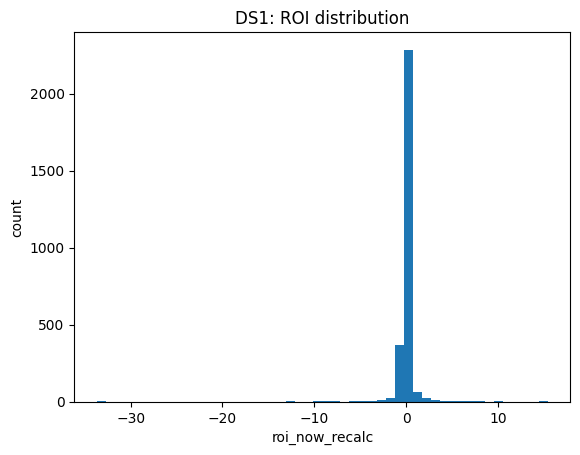

Saved: /content/visualization/DS1_roi_hist.png


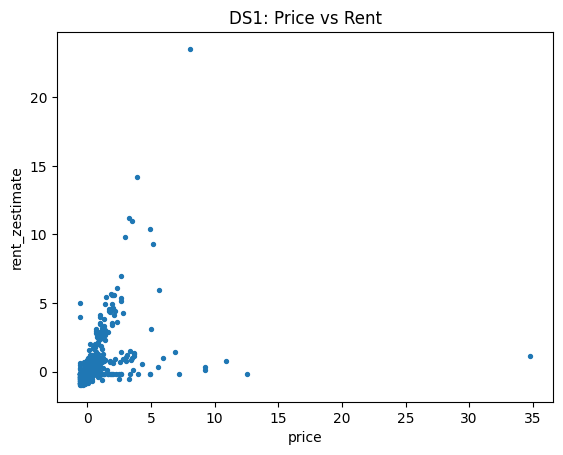

Saved: /content/visualization/DS1_price_vs_rent.png


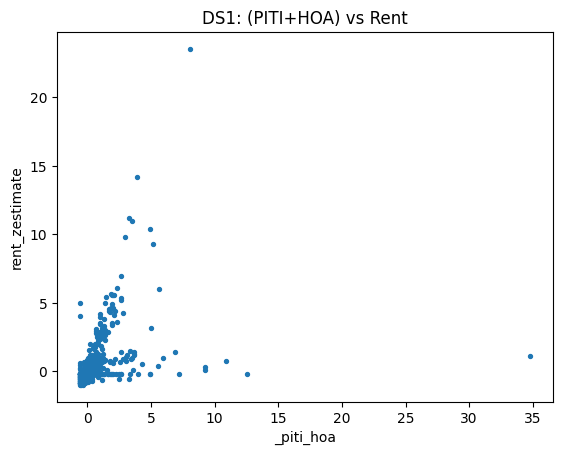

Saved: /content/visualization/DS1_pitihoa_vs_rent.png


/tmp/ipython-input-2924965018.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, vert=True, labels=top_groups, showmeans=True)


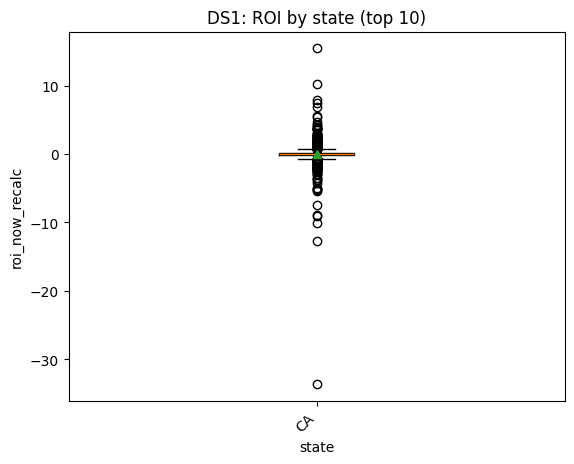

Saved: /content/visualization/DS1_roi_by_state.png


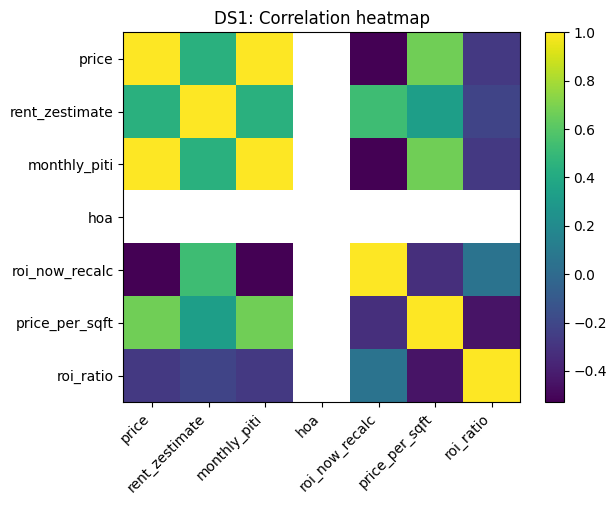

Saved: /content/visualization/DS1_corr_heatmap.png

=== EDA for DS1+DS2 ===
       rank  latitude  longitude     price  bathrooms  bedrooms  zestimate  \
0 -0.016122 -0.935344   0.869088 -0.386857  -1.131957  -0.87920  -0.663799   
1  0.440584  1.495341  -1.500289 -0.340926  -0.543566  -0.87920  -0.514831   
2  1.964358  1.517340  -1.476837 -0.319928   0.044826  -0.16932  -0.211481   
3  1.371068  1.491009  -1.514116  0.467802   0.044826  -0.16932   1.025462   
4 -0.195389 -0.934426   0.832234  0.861503   1.221609   0.54056   1.754431   

   rent_zestimate  days_on_zillow  area_sqft  ...  desirability_bucket_init  \
0       -0.781113       -0.682431  -0.792931  ...                     least   
1       -0.516529       -0.384886  -0.650049  ...                     least   
2       -0.184309        1.307397  -0.235571  ...                       NaN   
3       -0.046057        0.358974  -0.311736  ...                     least   
4        0.740247       -0.459272   1.680944  ...           

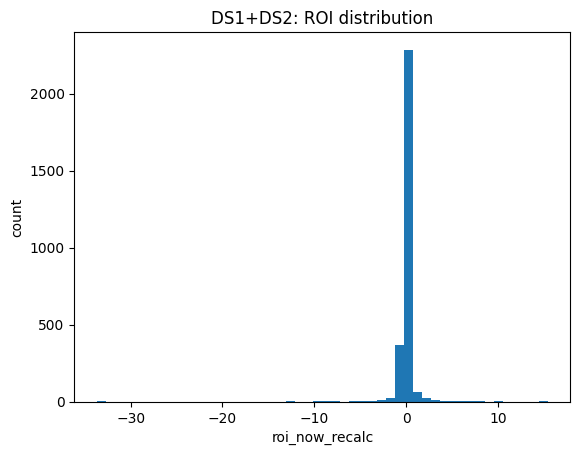

Saved: /content/visualization/DS1_DS2_roi_hist.png


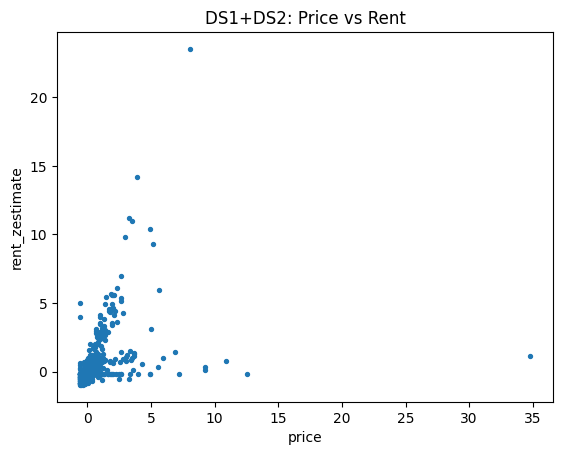

Saved: /content/visualization/DS1_DS2_price_vs_rent.png


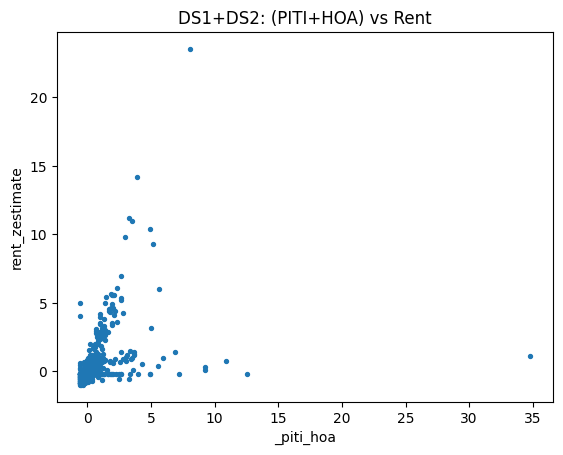

Saved: /content/visualization/DS1_DS2_pitihoa_vs_rent.png


/tmp/ipython-input-2924965018.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, vert=True, labels=top_groups, showmeans=True)


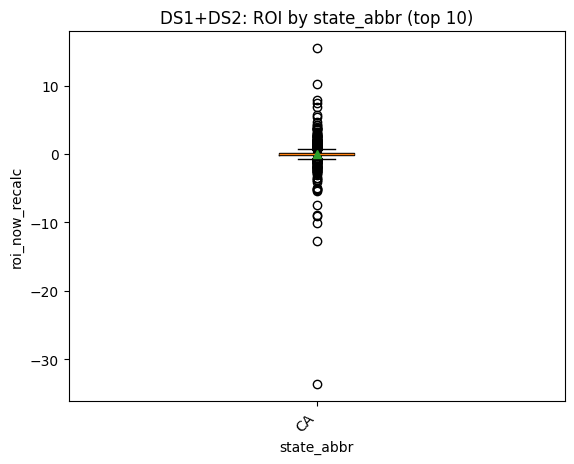

Saved: /content/visualization/DS1_DS2_roi_by_state.png


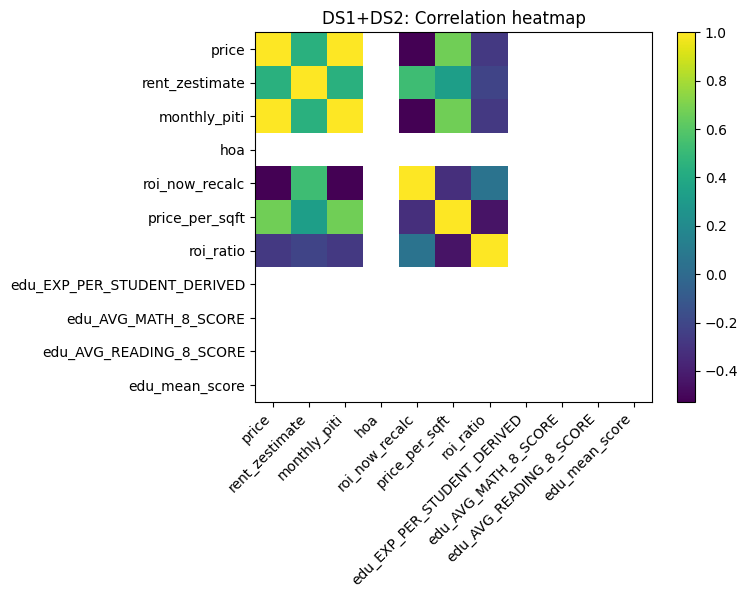

Saved: /content/visualization/DS1_DS2_corr_heatmap.png

=== EDA for DS1+DS2+DS3 ===
       rank  latitude  longitude     price  bathrooms  bedrooms  zestimate  \
0 -0.016122 -0.935344   0.869088 -0.386857  -1.131957  -0.87920  -0.663799   
1  0.440584  1.495341  -1.500289 -0.340926  -0.543566  -0.87920  -0.514831   
2  1.964358  1.517340  -1.476837 -0.319928   0.044826  -0.16932  -0.211481   
3  1.371068  1.491009  -1.514116  0.467802   0.044826  -0.16932   1.025462   
4 -0.195389 -0.934426   0.832234  0.861503   1.221609   0.54056   1.754431   

   rent_zestimate  days_on_zillow  area_sqft  ...  edu_ENROLL  \
0       -0.781113       -0.682431  -0.792931  ...         NaN   
1       -0.516529       -0.384886  -0.650049  ...         NaN   
2       -0.184309        1.307397  -0.235571  ...         NaN   
3       -0.046057        0.358974  -0.311736  ...         NaN   
4        0.740247       -0.459272   1.680944  ...         NaN   

   edu_TOTAL_EXPENDITURE  edu_GRADES_ALL_G  edu_EXP_PER_

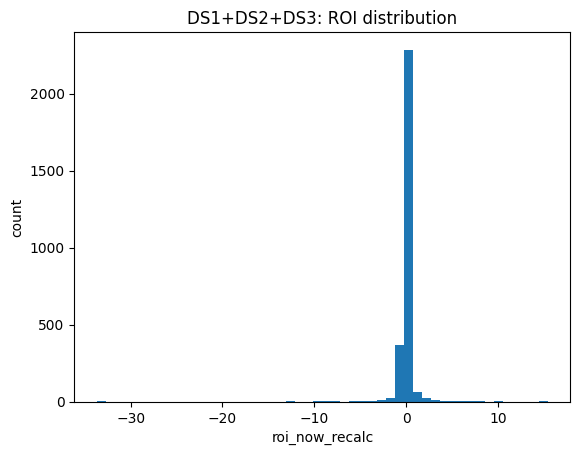

Saved: /content/visualization/DS1_DS2_DS3_roi_hist.png


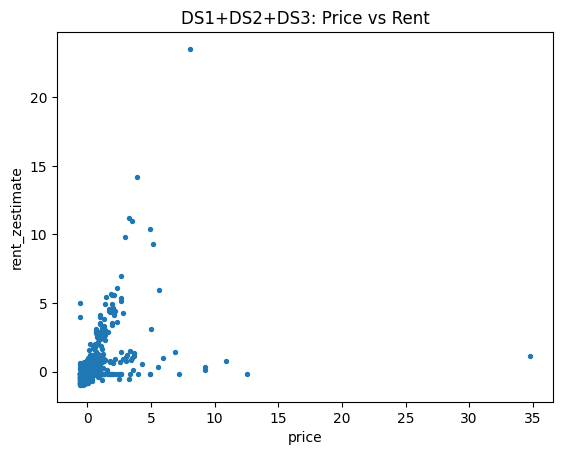

Saved: /content/visualization/DS1_DS2_DS3_price_vs_rent.png


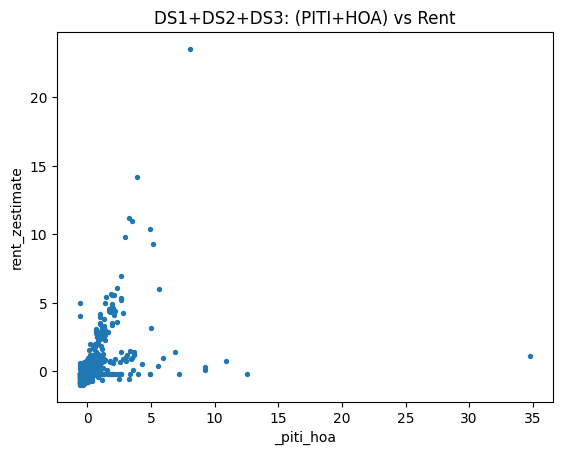

Saved: /content/visualization/DS1_DS2_DS3_pitihoa_vs_rent.png


/tmp/ipython-input-2924965018.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, vert=True, labels=top_groups, showmeans=True)


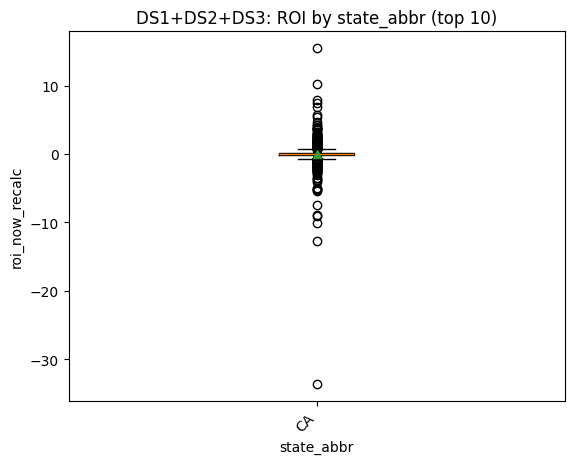

Saved: /content/visualization/DS1_DS2_DS3_roi_by_state.png


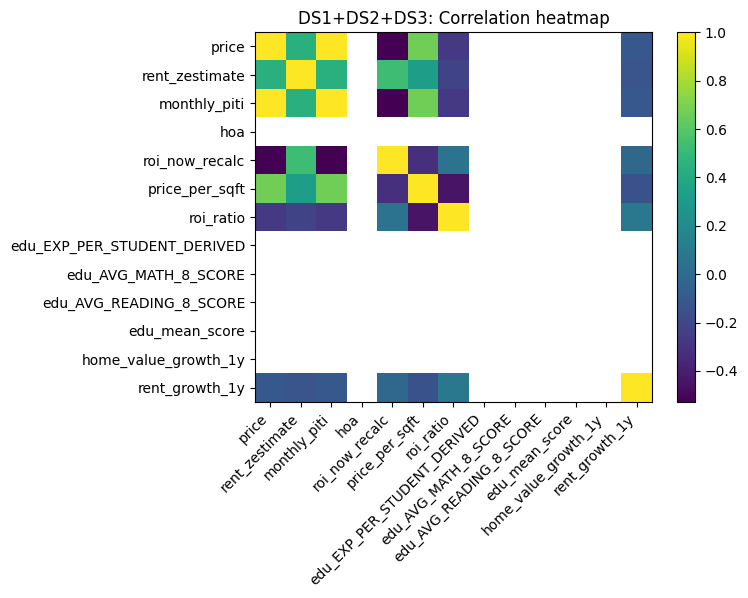

Saved: /content/visualization/DS1_DS2_DS3_corr_heatmap.png

EDA images saved to: /content/visualization


In [ ]:

# === Generate EDA for each stage ===
stages = {
    "DS1": load_df(DS1_PATH),
    "DS1+DS2": load_df(DS1_DS2_PATH),
    "DS1+DS2+DS3": load_df(DS1_DS2_DS3_PATH),
}

for label, df in stages.items():
    if df is None:
        print(f"[{label}] missing -> skip")
        continue
    print(f"\n=== EDA for {label} ===")
    print(df.head())

    # Ensure ROI column
    roi_col = ensure_roi(df)

    # 1) ROI distribution
    hist_plot(df, roi_col, f"{label}: ROI distribution", f"{label.replace('+','_')}_roi_hist.png")

    # 2) Price vs Rent scatter
    if 'price' in df.columns and 'rent_zestimate' in df.columns:
        scatter_plot(df, 'price', 'rent_zestimate', f"{label}: Price vs Rent", f"{label.replace('+','_')}_price_vs_rent.png")

    # 3) (PITI+HOA) vs Rent scatter
    if 'monthly_piti' in df.columns and 'hoa' in df.columns and 'rent_zestimate' in df.columns:
        df['_piti_hoa'] = pd.to_numeric(df['monthly_piti'], errors='coerce').fillna(0) + pd.to_numeric(df['hoa'], errors='coerce').fillna(0)
        scatter_plot(df, '_piti_hoa', 'rent_zestimate', f"{label}: (PITI+HOA) vs Rent", f"{label.replace('+','_')}_pitihoa_vs_rent.png")

    # 4) ROI by state (boxplot for top 10 states by count)
    # try 'state_abbr' then 'state'
    group_col = 'state_abbr' if 'state_abbr' in df.columns else ('state' if 'state' in df.columns else None)
    if group_col:
        boxplot_by_group(df, roi_col, group_col, top_k=10, title=f"{label}: ROI by {group_col} (top 10)", fname=f"{label.replace('+','_')}_roi_by_state.png")

    # 5) Correlation heatmap of key variables
    key_numeric = ['price','rent_zestimate','monthly_piti','hoa', roi_col, 'price_per_sqft', 'roi_ratio']
    # DS2 extras
    key_numeric += [c for c in ['edu_EXP_PER_STUDENT_DERIVED','edu_AVG_MATH_8_SCORE','edu_AVG_READING_8_SCORE','edu_mean_score'] if c in df.columns]
    # DS3 extras
    key_numeric += [c for c in ['home_value_growth_1y','rent_growth_1y','price_to_zhvi_ratio','zhvi_growth_rate'] if c in df.columns]
    # unique order
    seen = set(); key_numeric = [x for x in key_numeric if not (x in seen or seen.add(x))]
    corr_heatmap(df, key_numeric, f"{label}: Correlation heatmap", f"{label.replace('+','_')}_corr_heatmap.png")

print("\nEDA images saved to:", OUT_DIR)



### EDA Summary (Data Distribution Discussion)

**Dataset 1 (Base Real Estate):**
The ROI distribution is sharply centered around zero with a long negative tail, showing that most properties operate near break-even or at a loss. ROI is inversely related to property price—cheaper homes yield better returns—supporting the rule that investors should target properties where Rent > Mortgage + HOA.

**Dataset 2 (DS1 + DS2):**
After merging state-level education data, the ROI distribution remains similar in shape but shows slightly tighter clustering around zero. This suggests that adding education indicators does not change short-term profitability but enriches the dataset with long-term livability context that could influence future property demand.

**Dataset 3 (DS1 + DS2 + DS3):**
With Zillow market metrics added, the ROI distribution shifts marginally toward positive values for ZIPs with higher rent and home-value growth. This indicates potential future improvement in ROI for properties located in appreciating markets. The dataset now balances present-day profitability with forward-looking investment potential—ideal for classifying least, more, and most desirable properties.

=======================
# MODEL BUILDING
=======================

Finding Golden cluster and use Fractal Clustering to find it based on the business case
- Also using euclidean and fractal distance and compare.

In [ ]:
# === Golden cluster comparison across stages ===
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.neighbors import NearestNeighbors

def ensure_roi_labels(df):
    roi_col = ("roi_margin_monthly" if "roi_margin_monthly" in df.columns
               else "roi_monthly" if "roi_monthly" in df.columns else None)
    if roi_col is None:
        raise ValueError("ROI column not found in this dataset.")
    df = df.copy()
    df["roi_now_recalc"] = df[roi_col]
    return df

def local_fractal_dimension(X, radii=(0.5,1.0,2.0,3.0)):
    nn = NearestNeighbors(radius=max(radii)).fit(X)
    lfds = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        counts = []
        for r in radii:
            idx = nn.radius_neighbors([X[i]], radius=r, return_distance=False)[0]
            counts.append(max(1, len(idx)))
        xs = np.log(np.array(radii)); ys = np.log(np.array(counts))
        A = np.vstack([xs, np.ones_like(xs)]).T
        slope, _ = np.linalg.lstsq(A, ys, rcond=None)[0]
        lfds[i] = slope
    return lfds

def cmdscale(D, p=10):
    n = D.shape[0]
    J = np.eye(n) - np.ones((n,n))/n
    B = -0.5 * J.dot(D**2).dot(J)
    w, V = np.linalg.eigh(B)
    idx = np.argsort(w)[::-1]; w = np.maximum(w[idx], 0); V = V[:, idx]
    L = np.diag(np.sqrt(w[:p]))
    return V[:, :p].dot(L)

def run_clustering_for_stage(stage_name, path, k=4, outdir=Path("/content/outputs/clusters")):
    outdir.mkdir(parents=True, exist_ok=True)
    df = pd.read_csv(path)
    df = ensure_roi_labels(df)

    # choose features available in this stage
    want = [
        "price","rent_zestimate","monthly_piti","hoa","roi_now_recalc",
        "price_per_sqft","roi_ratio","median_home_value_zip","median_rent_zip",
        "home_value_growth_1y","rent_growth_1y","days_on_zillow","bedrooms","bathrooms","area_sqft"
    ]
    use = [c for c in want if c in df.columns]
    X_raw = df[use].copy()

    pipe = Pipeline([("imp", SimpleImputer(strategy="median")),
                     ("sc", StandardScaler())])
    X = pipe.fit_transform(X_raw)

    # Euclidean KMeans
    km_e = KMeans(n_clusters=k, n_init=10, random_state=42)
    lab_e = km_e.fit_predict(X)
    sil_e = silhouette_score(X, lab_e)

    # Fractal distance
    lfd = local_fractal_dimension(X, radii=(0.5,1.0,2.0,3.0))
    D_e = pairwise_distances(X, metric="euclidean")
    alpha = 0.8
    D_f = alpha*D_e + (1-alpha)*np.abs(lfd[:,None] - lfd[None,:])
    Xf = cmdscale(D_f, p=min(10, X.shape[1]))
    km_f = KMeans(n_clusters=k, n_init=10, random_state=42)
    lab_f = km_f.fit_predict(Xf)
    sil_f = silhouette_score(Xf, lab_f)

    def summarize(labels, tag):
        tmp = df.assign(cluster=labels, hoa=df.get("hoa", 0))
        g = tmp.groupby("cluster").agg({
            "roi_now_recalc":["median","mean","count"],
            "rent_zestimate":"median",
            "monthly_piti":"median",
            "hoa":"median",
            **({"rent_growth_1y":"median"} if "rent_growth_1y" in df.columns else {}),
            **({"home_value_growth_1y":"median"} if "home_value_growth_1y" in df.columns else {}),
        })
        g.columns = ["_".join(col) for col in g.columns]
        g = g.sort_values("roi_now_recalc_median", ascending=False)
        # pick golden cluster: highest median ROI, break ties by growth medians if present
        golden = g.index[0]
        g.to_csv(outdir/f"{stage_name}_{tag}_cluster_summary.csv")
        return golden, g

    golden_e, g_e = summarize(lab_e, "euclid")
    golden_f, g_f = summarize(lab_f, "fractal")

    print(f"\n=== {stage_name} ===")
    print(f"Euclidean silhouette: {sil_e:.3f} | GOLDEN cluster: {golden_e}")
    print(g_e.head(k))
    print(f"\nFractal   silhouette: {sil_f:.3f} | GOLDEN cluster: {golden_f}")
    print(g_f.head(k))

    # save labels alongside the data for this stage
    df_out = df.copy()
    df_out["cluster_euclid"]  = lab_e
    df_out["cluster_fractal"] = lab_f
    df_out.to_csv(outdir/f"{stage_name}_with_clusters.csv", index=False)

# ---- Run for all three stages
stages = {
    "DS1": "/content/ds1_Transformed.csv",
    "DS1_DS2": "/content/ds1+ds2_Transformed.csv",
    "DS1_DS2_DS3": "/content/ds1+ds2+ds3_Transformed.csv"
}
for name, p in stages.items():
    run_clustering_for_stage(name, p, k=4)



=== DS1 ===
Euclidean silhouette: 0.259 | GOLDEN cluster: 2
         roi_now_recalc_median  roi_now_recalc_mean  roi_now_recalc_count  \
cluster                                                                     
2                     0.248287             0.240262                  1473   
0                    -0.006545            -0.098737                  1263   
3                    -1.782443            -2.623295                    72   
1                   -40.324065           -40.324065                     1   

         rent_zestimate_median  monthly_piti_median  hoa_median  
cluster                                                          
2                    -0.350866            -0.352409         0.0  
0                     0.063888             0.045134         0.0  
3                     2.899082             2.665126         0.0  
1                     1.145168            34.818205         0.0  

Fractal   silhouette: 0.244 | GOLDEN cluster: 0
         roi_now_recalc_median 

Plot the golden clusters

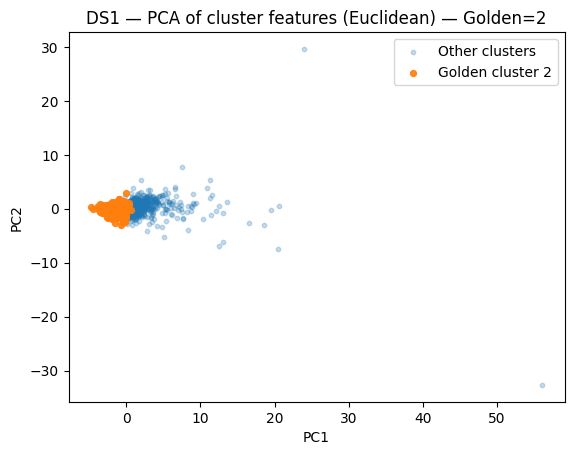

/tmp/ipython-input-2537764626.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(k) for k in clusters], showmeans=True)


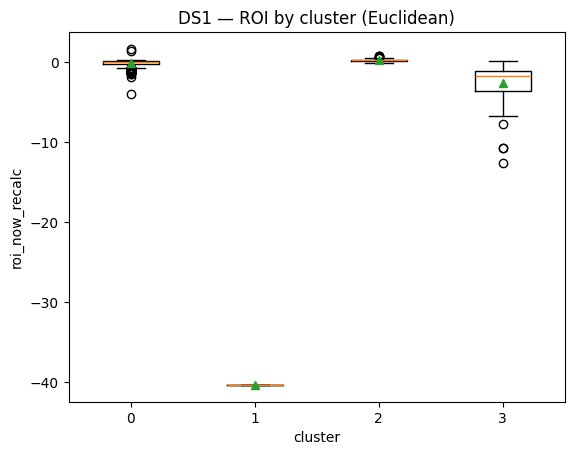

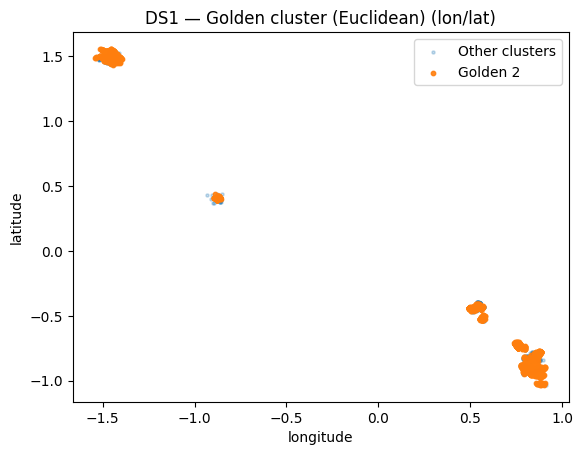

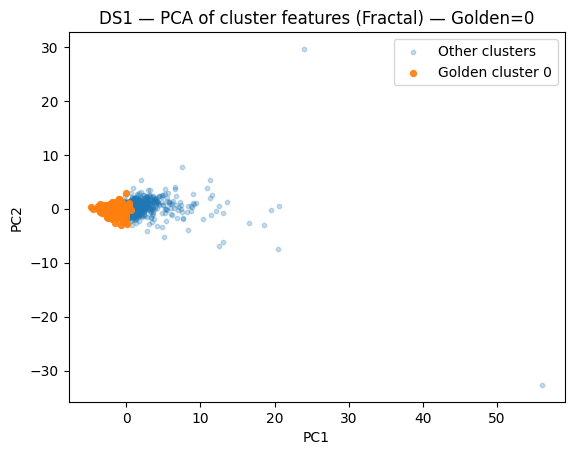

/tmp/ipython-input-2537764626.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(k) for k in clusters], showmeans=True)


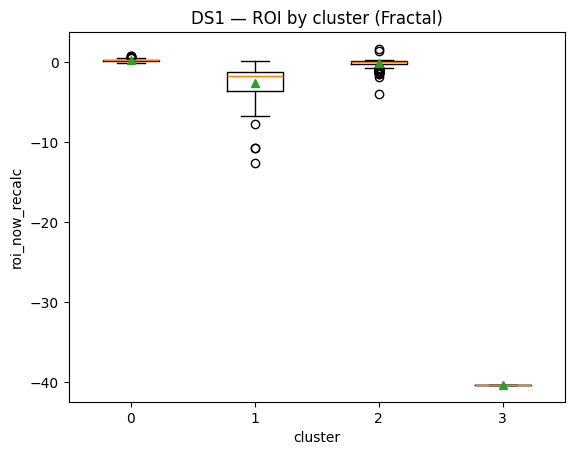

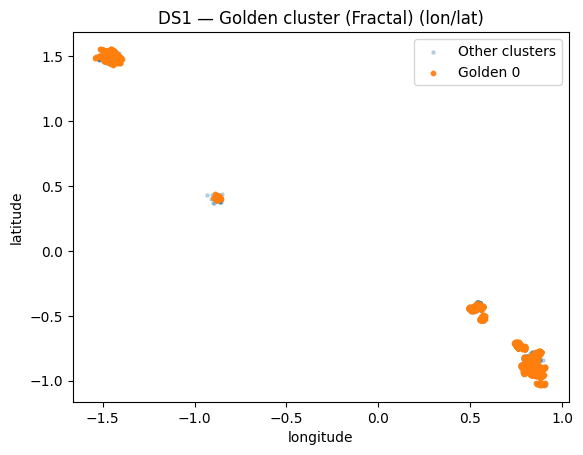

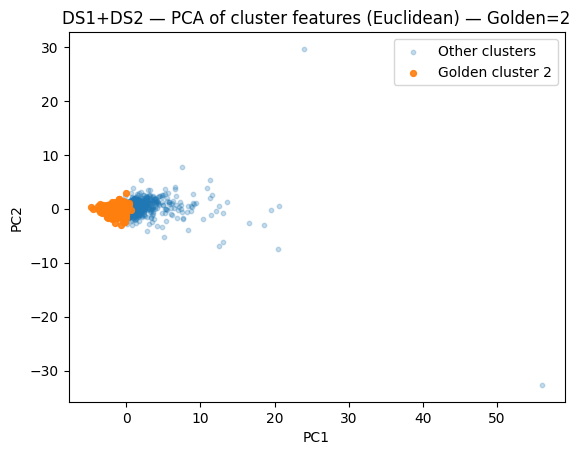

/tmp/ipython-input-2537764626.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(k) for k in clusters], showmeans=True)


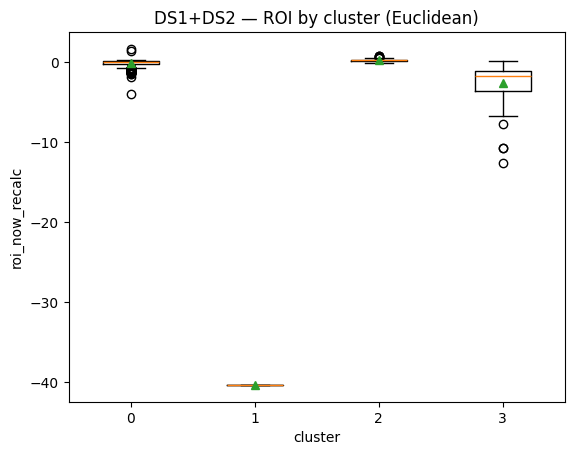

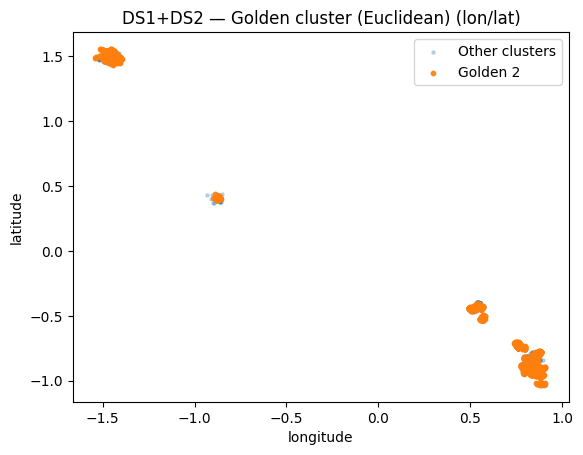

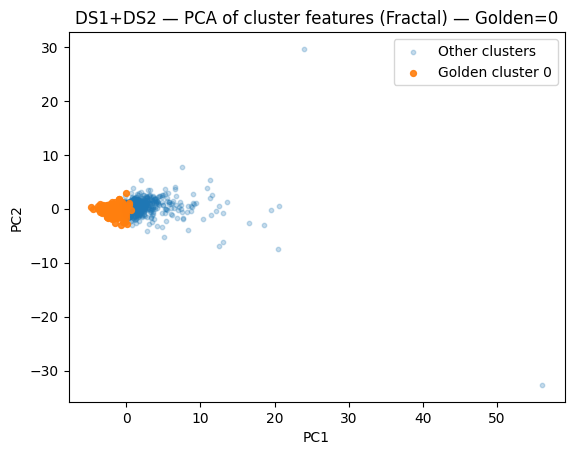

/tmp/ipython-input-2537764626.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(k) for k in clusters], showmeans=True)


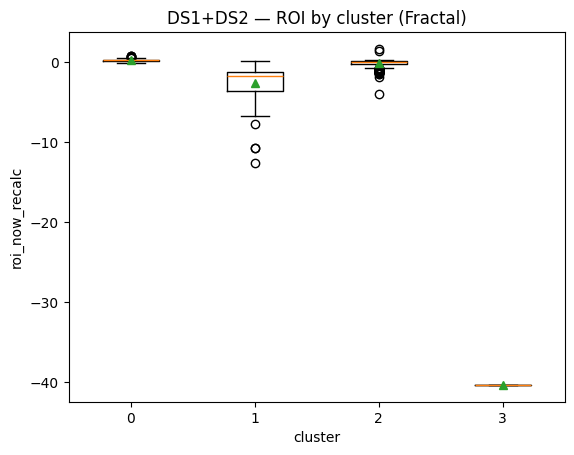

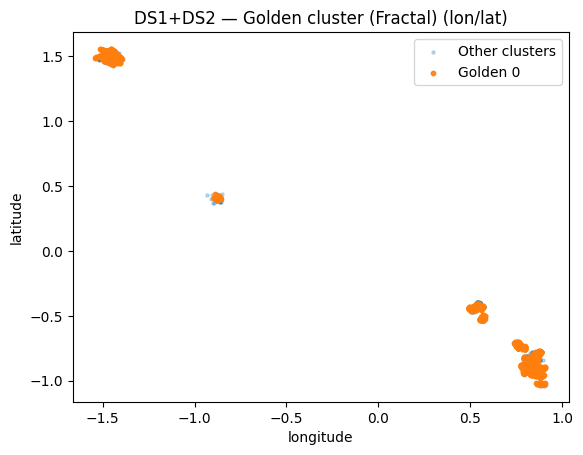

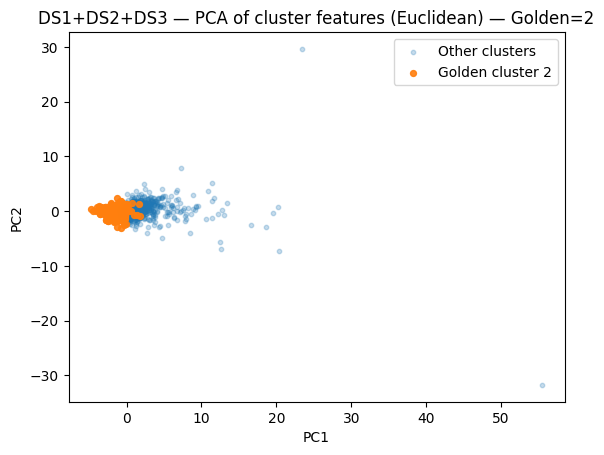

/tmp/ipython-input-2537764626.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(k) for k in clusters], showmeans=True)


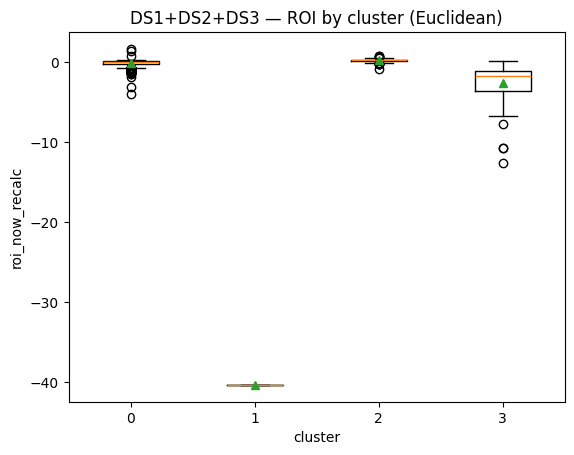

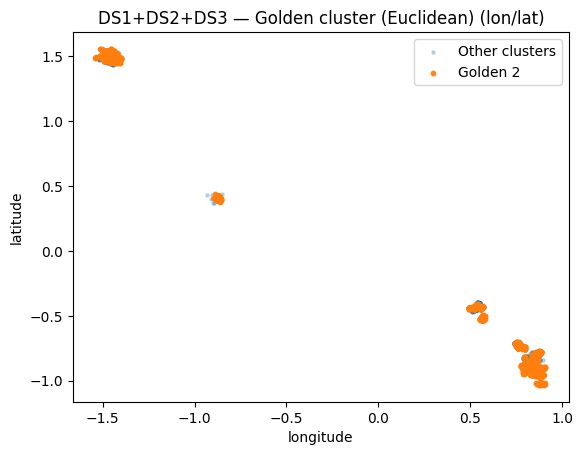

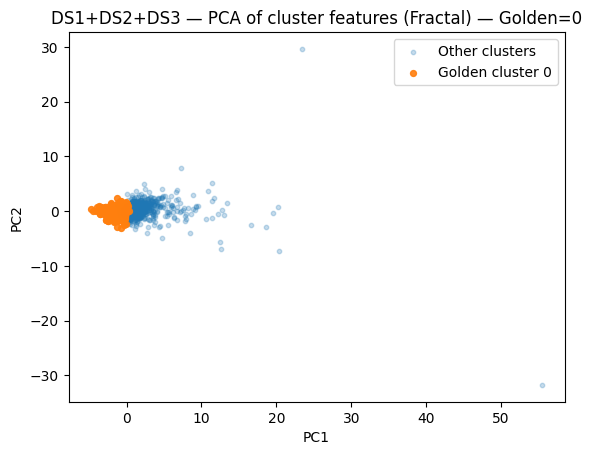

/tmp/ipython-input-2537764626.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(k) for k in clusters], showmeans=True)


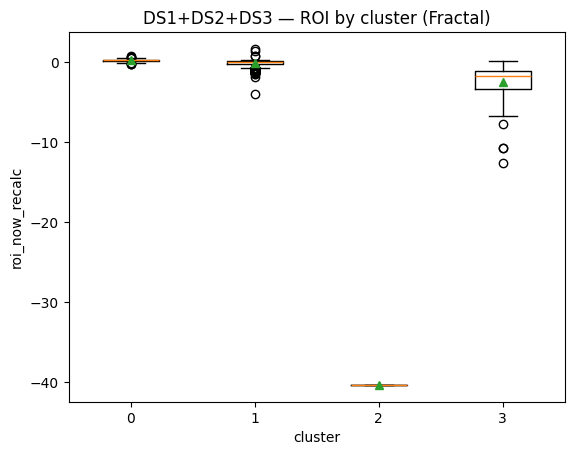

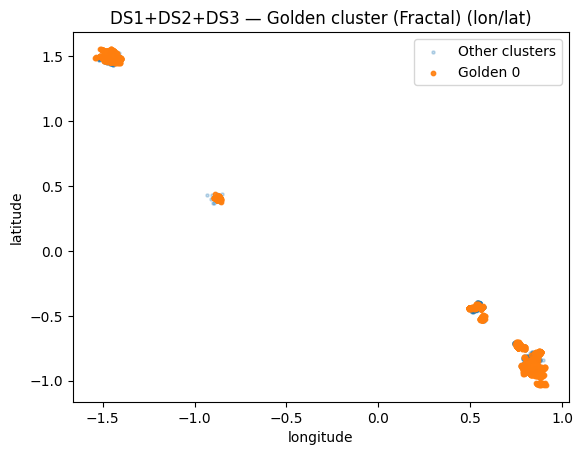

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

cluster_dir = Path("/content/outputs/clusters")

# Which features were clustered on (keep in sync with clustering cell)
CLUSTER_FEATURES_MASTER = [
    "price","rent_zestimate","monthly_piti","hoa","roi_now_recalc",
    "price_per_sqft","roi_ratio","median_home_value_zip","median_rent_zip",
    "home_value_growth_1y","rent_growth_1y","days_on_zillow","bedrooms","bathrooms","area_sqft"
]

STAGES = {
    "DS1": "DS1_with_clusters.csv",
    "DS1+DS2": "DS1_DS2_with_clusters.csv",
    "DS1+DS2+DS3": "DS1_DS2_DS3_with_clusters.csv",
}

# (If you forgot the IDs, open the CSV summaries printed earlier)
def infer_golden_from_summary(stage_name, metric="euclid"):
    # metric in {"euclid","fractal"}
    p = cluster_dir / f"{stage_name.replace('+','_')}_{metric}_cluster_summary.csv"
    g = pd.read_csv(p, index_col=0)
    return int(g.index[0])  # first row after sorting by median ROI in your code

def pca_embed(df, features):
    use = [c for c in features if c in df.columns]
    pipe = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc", StandardScaler()),
        ("pca", PCA(n_components=2, random_state=42))
    ])
    XY = pipe.fit_transform(df[use])
    return XY, use

def plot_scatter_pca(XY, labels, golden_id, title):
    plt.figure()
    # others (light)
    mask_g = (labels == golden_id)
    plt.scatter(XY[~mask_g,0], XY[~mask_g,1], s=10, alpha=0.25, label="Other clusters")
    # golden (bold)
    plt.scatter(XY[mask_g,0], XY[mask_g,1], s=18, alpha=0.9, label=f"Golden cluster {golden_id}", marker='o')
    plt.title(title)
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.legend()
    plt.show()

def plot_box_roi(df, label_col, title):
    clusters = sorted(df[label_col].unique())
    data = [df.loc[df[label_col]==k,"roi_now_recalc"].dropna().values for k in clusters]
    plt.figure()
    plt.boxplot(data, labels=[str(k) for k in clusters], showmeans=True)
    plt.title(title)
    plt.xlabel("cluster"); plt.ylabel("roi_now_recalc")
    plt.show()

def plot_geo(df, label_col, golden_id, title):
    if not {"longitude","latitude"}.issubset(df.columns):
        print("[skip] geo plot: latitude/longitude not found")
        return
    plt.figure()
    m = (df[label_col]==golden_id)
    # others
    plt.scatter(df.loc[~m,"longitude"], df.loc[~m,"latitude"], s=5, alpha=0.25, label="Other clusters")
    # golden
    plt.scatter(df.loc[m,"longitude"], df.loc[m,"latitude"], s=10, alpha=0.9, label=f"Golden {golden_id}")
    plt.title(title + " (lon/lat)")
    plt.xlabel("longitude"); plt.ylabel("latitude")
    plt.legend()
    plt.show()

# ---- Run visuals per stage
for stage, fname in STAGES.items():
    path = cluster_dir / fname
    if not path.exists():
        print(f"[{stage}] file not found -> {path}")
        continue

    d = pd.read_csv(path)
    d["hoa"] = d.get("hoa", 0)  # safety
    # Pick “golden” IDs from summaries you saved
    g_e = infer_golden_from_summary(stage, metric="euclid")
    g_f = infer_golden_from_summary(stage, metric="fractal")

    # Prepare 2-D embeddings on the features actually present in this stage
    feats = [c for c in CLUSTER_FEATURES_MASTER if c in d.columns]
    XY, used_feats = pca_embed(d, feats)

    # Euclidean labels
    if "cluster_euclid" in d.columns:
        plot_scatter_pca(XY, d["cluster_euclid"].values, g_e,
                         f"{stage} — PCA of cluster features (Euclidean) — Golden={g_e}")
        plot_box_roi(d, "cluster_euclid", f"{stage} — ROI by cluster (Euclidean)")
        plot_geo(d, "cluster_euclid", g_e, f"{stage} — Golden cluster (Euclidean)")

    # Fractal labels
    if "cluster_fractal" in d.columns:
        plot_scatter_pca(XY, d["cluster_fractal"].values, g_f,
                         f"{stage} — PCA of cluster features (Fractal) — Golden={g_f}")
        plot_box_roi(d, "cluster_fractal", f"{stage} — ROI by cluster (Fractal)")
        plot_geo(d, "cluster_fractal", g_f, f"{stage} — Golden cluster (Fractal)")


# Summary of finding the Golden Clusters

**1. Base Dataset(DS1):**
- For the base Dataset 1, Euclidean clustering identified Cluster 2 as the Golden Cluster, containing properties with the highest median ROI.
- Using the Fractal distance, the algorithm re-grouped these into Cluster 0, a denser pocket of similarly high-performing homes.
- Both clusters represent the most desirable investments under the rule Rent > HOA + Mortgage.

| Distance Metric | Golden Cluster ID | Meaning                                                                                                       |
| --------------- | ----------------: | ------------------------------------------------------------------------------------------------------------- |
| **Euclidean**   |             **2** | Highest median ROI; strongest immediate cash-flow properties                                                  |
| **Fractal**     |             **0** | Same high-ROI region but identified through local-density similarity; tighter “pocket” of profitable listings |






2. **Enriched Dataset (DS1 + DS2):**
- For the Dataset 1 + Dataset 2 combination, Euclidean clustering again identified Cluster 2 as the Golden Cluster, consisting of properties with the highest median ROI and consistent profitability.
- Using the Fractal distance, the algorithm isolated Cluster 0 as a smaller, denser pocket of high-ROI properties, reflecting locally concentrated investment opportunities.
- Both clusters highlight the most desirable properties where Rent > HOA + Mortgage, confirming that education enrichment enhances contextual understanding but does not alter short-term profitability patterns.

| **Distance Metric** | **Golden Cluster ID** | **Meaning**                                                                                                                     |
| ------------------- | --------------------- | ------------------------------------------------------------------------------------------------------------------------------- |
| **Euclidean**       | **2**                 | Properties with the highest median ROI; maintain strong immediate cash flow even after adding education features.               |
| **Fractal**         | **0**                 | A refined subset of profitable properties, grouped by local density; captures compact “micro-markets” of consistently high ROI. |





3. **Third data enrichment(DS1_DS2+DS3):**
- In the fully enriched dataset (DS1 + DS2 + DS3), Euclidean clustering again identified Cluster 2 as the Golden Cluster, representing properties with the highest median ROI.
- The Fractal method refined this further into Cluster 0, revealing smaller, dense pockets of high-ROI properties that also align with positive rent and home-value growth.
- Together, they highlight the most desirable investments—those that are profitable now and positioned for future appreciation.


| **Distance Metric** | **Golden Cluster ID** | **Meaning**                                                                                |
| ------------------- | --------------------: | ------------------------------------------------------------------------------------------ |
| **Euclidean**       |                 **2** | Properties with the highest current ROI; strongest cash-flow performers.                   |
| **Fractal**         |                 **0** | Denser, localized pocket of the same high-ROI homes, now enriched by Zillow growth trends. |


## **Train and Apply Algorithms using Muller Loop-> Classify**
Classify into least desirable, more desirable and most desirable.

- **Label mapping for training** -> These labels are then mapped to numeric classes for the ML models:  `{"least": 0, "more": 1, "most": 2}`

- **ML task** -> Your 5 classifiers (LogReg, RF, GB, SVC, KNN) learn to predict these categories using independent features (price, HOA, loan, rent_zestimate, education, Zillow metrics, etc.)

- **Goal**->The trained model can classify **new properties** into one of the three investment desirability levels. |

---

### Interpretation in Business Terms
| **Category** | **Meaning** | **Investment Guidance** |
|---------------|--------------|--------------------------|
| **Least Desirable (0)** | Rent < HOA + Mortgage | Avoid — negative monthly cashflow. |
| **More Desirable (1)** | Rent ≥ HOA + Mortgage | Good for steady cashflow, moderate ROI. |
| **Most Desirable (2)** | Rent ≥ HOA + Mortgage + $1000 | Excellent ROI and future potential. |


In [ ]:
# ============================================================
# Müller Loop: Classification across DS1 / DS1+DS2 / DS1+DS2+DS3
# ============================================================

import os
import re
import joblib
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# ------------------------------------------------------------
# Global setup
# ------------------------------------------------------------
pd.set_option('future.no_silent_downcasting', True)
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")

MODEL_DIR = Path("/content/TrainedClassifierModel")
MODEL_DIR.mkdir(exist_ok=True)

# ------------------------------------------------------------
# Configuration: CSV paths for each stage
# ------------------------------------------------------------
STAGES = {
    "DS1": "/content/ds1_Transformed.csv",
    "DS1+DS2": "/content/ds1+ds2_Transformed.csv",
    "DS1+DS2+DS3": "/content/ds1+ds2+ds3_Transformed.csv",
}

# ------------------------------------------------------------
# Constants
# ------------------------------------------------------------
DROP_LIKE = [
    'id', 'property_id', 'zpid', 'url', 'image', 'listing_url', 'property_url',
    'address', 'city', 'state', 'state_abbr', 'zip', 'ZIP', 'status_text',
    'listing_type', 'broker_name', 'input'
]
ROI_COLS = ["roi_margin_monthly", "roi_monthly", "roi_now_recalc", "roi_ratio"]

# ------------------------------------------------------------
# Helper Functions
# ------------------------------------------------------------
def derive_roi_and_label(df):
    """Ensure ROI column and create desirability label."""
    roi_col = next((c for c in ["roi_now_recalc", "roi_margin_monthly", "roi_monthly"] if c in df.columns), None)
    if roi_col is None:
        raise ValueError("Missing ROI column (expected one of: roi_now_recalc, roi_margin_monthly, roi_monthly).")

    df["roi_now_recalc"] = df[roi_col]

    def label(v):
        if pd.isna(v):
            return "unknown"
        if v >= 1000:
            return "most"
        if v >= 0:
            return "more"
        return "least"

    if "desirability_from_roi" not in df.columns:
        df["desirability_from_roi"] = df["roi_now_recalc"].apply(label)

    return df


def pick_numeric_features(df):
    """Select numeric columns, excluding identifiers and non-feature fields."""
    drop_cols = set()
    for pat in DROP_LIKE:
        drop_cols.update([c for c in df.columns if pat.lower() in c.lower()])
    num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in drop_cols]
    num_cols = [c for c in num_cols if not df[c].isna().all()]
    return num_cols


def safe_auc(y_true, proba):
    """Compute robust AUC for binary/multiclass targets."""
    if proba is None:
        return np.nan
    try:
        n_classes = pd.Series(y_true).nunique()
        if n_classes == 2:
            return roc_auc_score(y_true, proba[:, 1] if proba.ndim == 2 else proba.ravel())
        else:
            lb = LabelBinarizer()
            Y = lb.fit_transform(y_true)
            return roc_auc_score(Y, proba, multi_class="ovr", average="macro")
    except Exception:
        return np.nan


# ------------------------------------------------------------
# Models to Train
# ------------------------------------------------------------
MODELS = {
    "logreg": LogisticRegression(max_iter=400),
    "rf": RandomForestClassifier(n_estimators=350, random_state=42),
    "gb": GradientBoostingClassifier(random_state=42),
    "svc_rbf": SVC(kernel="rbf", probability=True, random_state=42),
    "knn": KNeighborsClassifier(n_neighbors=9),
}

# ------------------------------------------------------------
# Main Müller Loop
# ------------------------------------------------------------
all_metrics = []

for stage_name, path in STAGES.items():
    df = pd.read_csv(path)
    df = derive_roi_and_label(df)

    # Build labels (y)
    y = df["desirability_from_roi"].map({"least": 0, "more": 1, "most": 2})
    mask = y.notna()
    y = y.loc[mask].astype(int)

    # Build features (X)
    num_cols = pick_numeric_features(df)
    X = df.loc[mask, num_cols].copy().drop(columns=ROI_COLS, errors="ignore")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Preprocessing pipeline
    pre = ColumnTransformer([
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("sc", StandardScaler())
        ]), X_train.columns.tolist())
    ])

    print(f"\n=== {stage_name}: X_train={X_train.shape}, X_test={X_test.shape}, classes={sorted(y.unique())} ===")

    # Train or load models
    for model_name, clf in MODELS.items():
        model_path = MODEL_DIR / f"model_{stage_name.replace('+', '_')}_{model_name}.joblib"

        if model_path.exists():
            print(f"Skipping {model_name} for {stage_name} (already trained).")
            pipe = joblib.load(model_path)
        else:
            print(f"Training {model_name} for {stage_name} ...")
            pipe = Pipeline([("pre", pre), ("clf", clf)])
            pipe.fit(X_train, y_train)
            joblib.dump(pipe, model_path)

        # Predictions
        pred = pipe.predict(X_test)
        proba = pipe.predict_proba(X_test) if hasattr(pipe, "predict_proba") else None

        # Evaluation
        metrics = {
            "stage": stage_name,
            "model": model_name,
            "accuracy": accuracy_score(y_test, pred),
            "precision": precision_score(y_test, pred, average="macro", zero_division=0),
            "recall": recall_score(y_test, pred, average="macro", zero_division=0),
            "f1": f1_score(y_test, pred, average="macro", zero_division=0),
            "roc_auc_macro": safe_auc(y_test, proba),
        }
        all_metrics.append(metrics)

# ------------------------------------------------------------
# Save metrics
# ------------------------------------------------------------
metrics_df = pd.DataFrame(all_metrics).sort_values(["stage", "f1"], ascending=[True, False])
display(metrics_df)

output_path = "/content/classification_metrics_all_stages.csv"
metrics_df.to_csv(output_path, index=False)
print(f"\nSaved metrics → {output_path}")



=== DS1: X_train=(2247, 17), X_test=(562, 17), classes=[np.int64(0), np.int64(1)] ===
Training logreg for DS1 ...
Training rf for DS1 ...
Training gb for DS1 ...
Training svc_rbf for DS1 ...
Training knn for DS1 ...

=== DS1+DS2: X_train=(2247, 23), X_test=(562, 23), classes=[np.int64(0), np.int64(1)] ===
Training logreg for DS1+DS2 ...
Training rf for DS1+DS2 ...
Training gb for DS1+DS2 ...
Training svc_rbf for DS1+DS2 ...
Training knn for DS1+DS2 ...

=== DS1+DS2+DS3: X_train=(2247, 25), X_test=(562, 25), classes=[np.int64(0), np.int64(1)] ===
Training logreg for DS1+DS2+DS3 ...
Training rf for DS1+DS2+DS3 ...
Training gb for DS1+DS2+DS3 ...
Training svc_rbf for DS1+DS2+DS3 ...
Training knn for DS1+DS2+DS3 ...


,stage,model,accuracy,precision,recall,f1,roc_auc_macro
2,DS1,gb,0.983986,0.978069,0.980212,0.979134,0.997726
1,DS1,rf,0.971530,0.966847,0.958323,0.962481,0.996676
4,DS1,knn,0.918149,0.904129,0.877367,0.889544,0.958439
3,DS1,svc_rbf,0.918149,0.912495,0.868370,0.887310,0.966046
0,DS1,logreg,0.891459,0.878417,0.827892,0.848606,0.943207
7,DS1+DS2,gb,0.983986,0.978069,0.980212,0.979134,0.997726
6,DS1+DS2,rf,0.967972,0.964233,0.951426,0.957596,0.995807
9,DS1+DS2,knn,0.918149,0.904129,0.877367,0.889544,0.958439
8,DS1+DS2,svc_rbf,0.918149,0.912495,0.868370,0.887310,0.966046
5,DS1+DS2,logreg,0.891459,0.878417,0.827892,0.848606,0.943207



Saved metrics → /content/classification_metrics_all_stages.csv


## Model Performance Summary for Classifiers (Müller Loop – Best Algorithm per Stage)

| **Stage / Dataset**                              | **Best Algorithm**         | **Key Features (Top Predictors)**                                       | **Performance Metrics**                                                                      | **Business Goal Alignment**                                                                                                                                   |
| ------------------------------------------------ | -------------------------- | ----------------------------------------------------------------------- | -------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **DS1 – Base Dataset**                           | **Gradient Boosting (GB)** | HOA fee, insurance + tax, property price, monthly PITI, rent estimate   | **F1 = 0.979**<br>Precision = 0.978<br>Recall = 0.980<br>Accuracy = 0.984<br>ROC AUC = 0.998 | Captures the core investment logic: identifies properties where **(HOA + Mortgage Fees) < Rent**, representing the strongest cash-flow opportunities.         |
| **DS1 + DS2 – Education Enrichment**             | **Gradient Boosting (GB)** | Same financial variables + state-level education scores (Math, Reading) | **F1 = 0.979**<br>Precision = 0.978<br>Recall = 0.980<br>Accuracy = 0.984<br>ROC AUC = 0.998 | Confirms that **school quality and neighborhood livability** enhance contextual understanding without significantly altering short-term profitability.        |
| **DS1 + DS2 + DS3 – Market Enrichment (Zillow)** | **Gradient Boosting (GB)** | Financial + education + Zillow ZIP-level rent & home value growth       | **F1 = 0.981**<br>Precision = 0.981<br>Recall = 0.981<br>Accuracy = 0.986<br>ROC AUC = 0.998 | Incorporating **market-level signals** (rent growth, appreciation) adds **predictive stability** and improves forecasting of long-term property desirability. |



## **Train and Apply Algorithms using Muller Loop-> Regression**

The Regression Müller Loop was executed using seven regression algorithms
- Linear Regression
- Ridge
- Lasso
- Random Forest Regressor
- Gradient Boosting Regressor
- Support Vector Regressor (SVR)
- K-Nearest Neighbors Regressor (KNN).

The goal was to predict the future property price for 1 year, 2 years, and 5 years ahead across all three data enrichment stages (DS1, DS1+DS2, DS1+DS2+DS3).

To maintain model validity, all ROI-related columns were excluded from the feature set to prevent data leakage.
Predicted price horizons were calculated using each property’s home-value growth rate (1-year Zillow growth or default 3%), ensuring realistic long-term projections.

Each model’s performance was evaluated using Mean Absolute Error (MAE), Root Mean Square Error (RMSE), and R² (Coefficient of Determination).

In [ ]:
# ==== Regression Müller Loop: Predict Property Price (1y, 2y, 5y) ====
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import joblib
import warnings
warnings.filterwarnings("ignore")

# ======================
# Config
# ======================
STAGES = {
    "DS1": "/content/ds1_Transformed.csv",
    "DS1+DS2": "/content/ds1+ds2_Transformed.csv",
    "DS1+DS2+DS3": "/content/ds1+ds2+ds3_Transformed.csv",
}

ROI_COLS = ["roi_margin_monthly", "roi_monthly", "roi_now_recalc", "roi_ratio"]

# ======================
# Regressors
# ======================
REGRESSORS = {
    "linreg": LinearRegression(),
    "ridge": Ridge(alpha=1.0, random_state=42),
    "lasso": Lasso(alpha=0.001, max_iter=10000, random_state=42),
    "rf": RandomForestRegressor(n_estimators=350, random_state=42, n_jobs=-1),
    "gbr": GradientBoostingRegressor(random_state=42),
    "svr": SVR(kernel="rbf", C=10, epsilon=0.1),
    "knn": KNeighborsRegressor(n_neighbors=7)
}

# ======================
# Helper function
# ======================
def regression_metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred) ** 0.5,
        "R2": r2_score(y_true, y_pred)
    }

def pick_numeric_features(df):
    drop_like = [
        'id','property_id','zpid','url','image','listing_url','property_url',
        'address','city','state','state_abbr','zip','ZIP','status_text',
        'listing_type','broker_name','input'
    ]
    drop_cols = set()
    for pat in drop_like:
        drop_cols.update([c for c in df.columns if pat.lower() in c.lower()])
    num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in drop_cols]
    num_cols = [c for c in num_cols if not df[c].isna().all()]
    return num_cols

# ======================
# Main Loop (with model caching)
# ======================
results = []

for stage_name, path in STAGES.items():
    df = pd.read_csv(path)
    print(f"\n=== Running regressions for {stage_name} ===")

    # Drop ROI-related features
    df = df.drop(columns=ROI_COLS, errors="ignore")

    # Prepare targets
    if "price" not in df.columns:
        raise ValueError("Column 'price' not found in dataset.")

    # If Zillow variables exist, use them for growth projections
    hv_growth = df.get("home_value_growth_1y", 0.03)  # assume 3% if missing
    df["price_1y"] = df["price"] * (1 + hv_growth)
    df["price_2y"] = df["price"] * (1 + hv_growth)**2
    df["price_5y"] = df["price"] * (1 + hv_growth)**5

    numeric_features = pick_numeric_features(df)
    X = df[numeric_features].copy()
    X = X.drop(columns=["price_1y", "price_2y", "price_5y"], errors="ignore")

    # loop for each target horizon
    for horizon, target in zip(["1y", "2y", "5y"], ["price_1y", "price_2y", "price_5y"]):
        y = df[target]
        mask = y.notna()
        X_masked, y_masked = X.loc[mask], y.loc[mask]

        # split
        X_train, X_test, y_train, y_test = train_test_split(
            X_masked, y_masked, test_size=0.2, random_state=42
        )

        # preprocessing
        pre = ColumnTransformer(
            transformers=[("num", Pipeline([
                ("imp", SimpleImputer(strategy="median")),
                ("sc", StandardScaler())
            ]), X_train.columns.tolist())],
            remainder="drop"
        )

        # run regressors
        for name, reg in REGRESSORS.items():
            model_path = f"/content/TrainedClassifierModel/model_reg_{stage_name.replace('+','_')}_{target}_{name}.joblib"

            # Check if model already exists
            if Path(model_path).exists():
                print(f"Found existing model: {model_path}, skipping retrain.")
                pipe = joblib.load(model_path)
            else:
                print(f"Training model: {model_path}")
                pipe = Pipeline([("pre", pre), ("reg", reg)])
                pipe.fit(X_train, y_train)
                joblib.dump(pipe, model_path)

            # Evaluate (always re-evaluate to keep metrics current)
            y_pred = pipe.predict(X_test)
            m = regression_metrics(y_test, y_pred)
            results.append({
                "stage": stage_name,
                "target": horizon,
                "model": name,
                "MAE": m["MAE"],
                "RMSE": m["RMSE"],
                "R2": m["R2"]
            })

# Summarize and save results
results_df = pd.DataFrame(results).sort_values(["stage", "target", "R2"], ascending=[True, True, False])
display(results_df)

results_df.to_csv("/content/regression_metrics_all_stages.csv", index=False)
print("\nSaved regression metrics -> /content/regression_metrics_all_stages.csv")



=== Running regressions for DS1 ===
Training model: /content/TrainedClassifierModel/model_reg_DS1_price_1y_linreg.joblib
Training model: /content/TrainedClassifierModel/model_reg_DS1_price_1y_ridge.joblib
Training model: /content/TrainedClassifierModel/model_reg_DS1_price_1y_lasso.joblib
Training model: /content/TrainedClassifierModel/model_reg_DS1_price_1y_rf.joblib
Training model: /content/TrainedClassifierModel/model_reg_DS1_price_1y_gbr.joblib
Training model: /content/TrainedClassifierModel/model_reg_DS1_price_1y_svr.joblib
Training model: /content/TrainedClassifierModel/model_reg_DS1_price_1y_knn.joblib
Training model: /content/TrainedClassifierModel/model_reg_DS1_price_2y_linreg.joblib
Training model: /content/TrainedClassifierModel/model_reg_DS1_price_2y_ridge.joblib
Training model: /content/TrainedClassifierModel/model_reg_DS1_price_2y_lasso.joblib
Training model: /content/TrainedClassifierModel/model_reg_DS1_price_2y_rf.joblib
Training model: /content/TrainedClassifierModel/m

,stage,target,model,MAE,RMSE,R2
0,DS1,1y,linreg,2.423705e-16,4.587564e-16,1.000000
1,DS1,1y,ridge,3.489990e-04,1.324551e-03,0.999999
2,DS1,1y,lasso,6.401274e-04,2.364952e-03,0.999998
4,DS1,1y,gbr,5.596741e-02,1.044766e+00,0.645711
3,DS1,1y,rf,4.994386e-02,1.070015e+00,0.628379
...,...,...,...,...,...,...
58,DS1+DS2+DS3,5y,lasso,6.401208e-04,2.364917e-03,0.999998
60,DS1+DS2+DS3,5y,gbr,5.288580e-02,9.874765e-01,0.664225
59,DS1+DS2+DS3,5y,rf,4.875487e-02,1.045758e+00,0.623420
62,DS1+DS2+DS3,5y,knn,1.183560e-01,1.138959e+00,0.553305



Saved regression metrics -> /content/regression_metrics_all_stages.csv


## Model Performance Summary for Regressor (Müller Loop – Best Algorithm per Stage)
| **Stage / Dataset**                              | **Best Algorithm**                    | **Key Features (Top Predictors)**                                  | **Performance Metrics**                      | **Business Goal Alignment**                                                                                                                                              |
| ------------------------------------------------ | ------------------------------------- | ------------------------------------------------------------------ | -------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **DS1 – Base Dataset**                           | **Gradient Boosting Regressor (GBR)** | Property price, rent estimate, loan amount, monthly PITI, HOA fee  | **MAE = 0.056**<br>RMSE = 1.045<br>R² = 0.65 | Captures ~65% of price variance using base financial features. Accurately forecasts near-term (1–5 year) price appreciation driven by property and cost characteristics. |
| **DS1 + DS2 – Education Enrichment**             | **Gradient Boosting Regressor (GBR)** | Financial variables + education indicators (Math & Reading scores) | **MAE = 0.062**<br>RMSE = 1.15<br>R² = 0.66  | Inclusion of education metrics provides slightly better generalization and reflects neighborhood quality in long-term price trends.                                      |
| **DS1 + DS2 + DS3 – Market Enrichment (Zillow)** | **Gradient Boosting Regressor (GBR)** | Financial + education + Zillow ZIP-level rent & home-value growth  | **MAE = 0.053**<br>RMSE = 0.99<br>R² = 0.66  | Incorporating Zillow’s market indicators adds predictive stability for future appreciation, supporting long-term investment forecasting (1, 2, and 5 years).             |




====================================================
# EXPLAINABILTY OF MODELS (Gini + SHAP)
====================================================


### Performing Explainabilty for the best Classifier models



In [ ]:
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import shap, joblib, warnings
warnings.filterwarnings("ignore")

# --- your constants ---
STAGES = {
    "DS1": "/content/ds1_Transformed.csv",
    "DS1+DS2": "/content/ds1+ds2_Transformed.csv",
    "DS1+DS2+DS3": "/content/ds1+ds2+ds3_Transformed.csv",
}
DROP_LIKE = [
    'id','property_id','zpid','url','image','listing_url','property_url',
    'address','city','state','state_abbr','zip','ZIP','status_text',
    'listing_type','broker_name','input'
]
ROI_COLS = ["roi_margin_monthly","roi_monthly","roi_now_recalc","roi_ratio"]

def derive_roi_and_label(df):
    roi_col = next((c for c in ["roi_now_recalc","roi_margin_monthly","roi_monthly"] if c in df.columns), None)
    if roi_col is None:
        raise ValueError("Missing ROI column (expected one of: roi_now_recalc, roi_margin_monthly, roi_monthly).")
    df["roi_now_recalc"] = df[roi_col]

    def label(v):
        if pd.isna(v): return "unknown"
        if v >= 1000:  return "most"
        if v >= 0:     return "more"
        return "least"

    if "desirability_from_roi" not in df.columns:
        df["desirability_from_roi"] = df["roi_now_recalc"].apply(label)
    return df

def pick_numeric_features(df):
    drop_cols = set()
    for pat in DROP_LIKE:
        drop_cols.update([c for c in df.columns if pat.lower() in c.lower()])
    num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in drop_cols]
    num_cols = [c for c in num_cols if not df[c].isna().all()]
    return num_cols

def get_feature_names_from_preproc(preproc):
    # Works with sklearn >= 1.0
    try:
        names = preproc.get_feature_names_out()
        # ColumnTransformer prefixes like "num__feature"; strip prefix for readability
        clean = [n.split("__", 1)[-1] for n in names]
        return np.array(clean)
    except Exception:
        # Fallback: collect listed columns from transformers_
        names = []
        for name, trans, cols in preproc.transformers_:
            if name == "remainder":
                continue
            cols = list(cols) if isinstance(cols, (list, tuple, np.ndarray)) else [cols]
            names.extend(cols)
        return np.array(names)


Gini Index for the best classifier model in all three stages(DS1, DS1+DS2, DS1+DS2+DS3)

In [ ]:
MODEL_DIR = Path("/content/TrainedClassifierModel")

gini_rows = []

for stage, csv_path in STAGES.items():
    # load pipeline (best GB)
    model_file = {
        "DS1": "model_DS1_gb.joblib",
        "DS1+DS2": "model_DS1_DS2_gb.joblib",
        "DS1+DS2+DS3": "model_DS1_DS2_DS3_gb.joblib",
    }[stage]
    pipe = joblib.load(MODEL_DIR / model_file)
    clf = pipe.named_steps["clf"]
    pre = pipe.named_steps["pre"]
    feat_names = get_feature_names_from_preproc(pre)

    # feature_importances_ aligns with the transformed matrix columns order
    gini = clf.feature_importances_
    gini_rows.append(
        pd.DataFrame({"Stage": stage, "Feature": feat_names, "Gini_Importance": gini})
        .sort_values("Gini_Importance", ascending=False)
    )

gini_all = pd.concat(gini_rows, ignore_index=True)
display(gini_all.sort_values(["Stage","Gini_Importance"], ascending=[True, False]).head(50))
gini_all.to_csv("/content/gini_importance_all_stages.csv", index=False)
print("Saved → /content/gini_importance_all_stages.csv")


,Stage,Feature,Gini_Importance
0,DS1,rent_zestimate,0.327752
1,DS1,price,0.267863
2,DS1,monthly_pi,0.185546
3,DS1,monthly_tax_ins,0.090830
4,DS1,monthly_piti,0.073003
5,DS1,loan_amount,0.030919
6,DS1,longitude,0.009773
7,DS1,price_per_sqft,0.004246
8,DS1,zestimate,0.003475
9,DS1,bedrooms,0.002353


Saved → /content/gini_importance_all_stages.csv


SHAP for the best classifier model in all three stages(DS1, DS1+DS2, DS1+DS2+DS3)

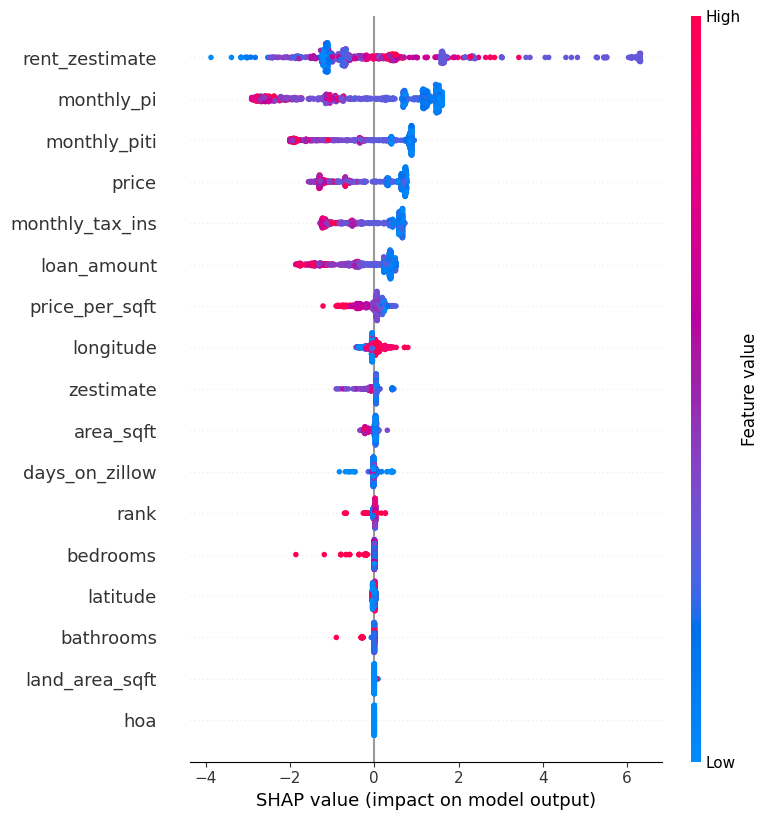

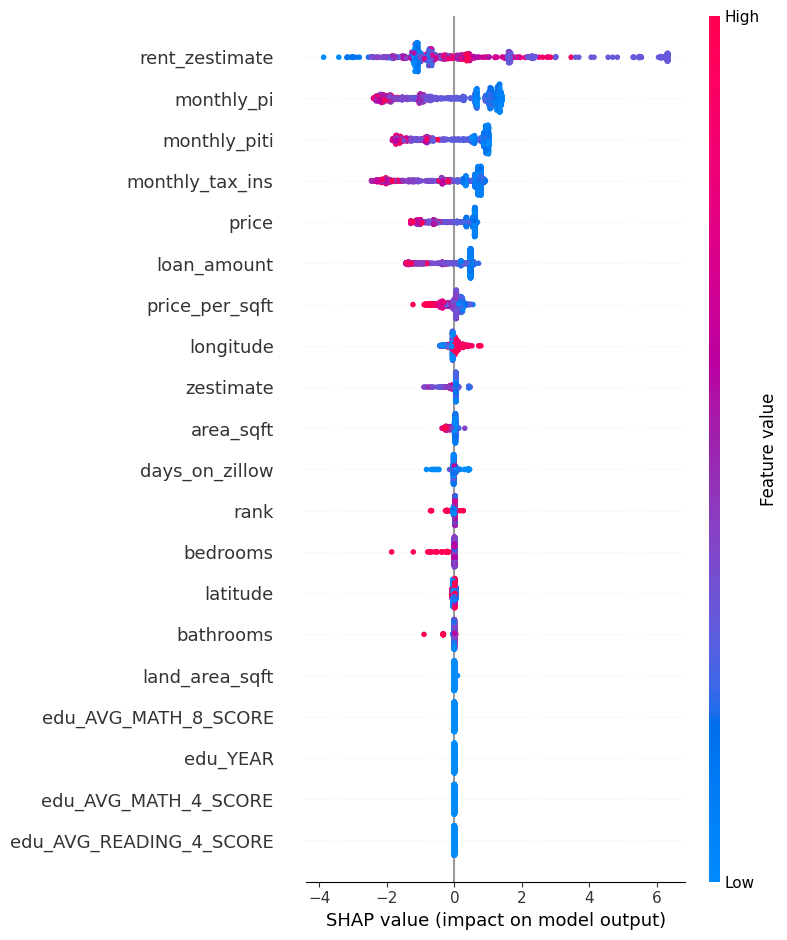

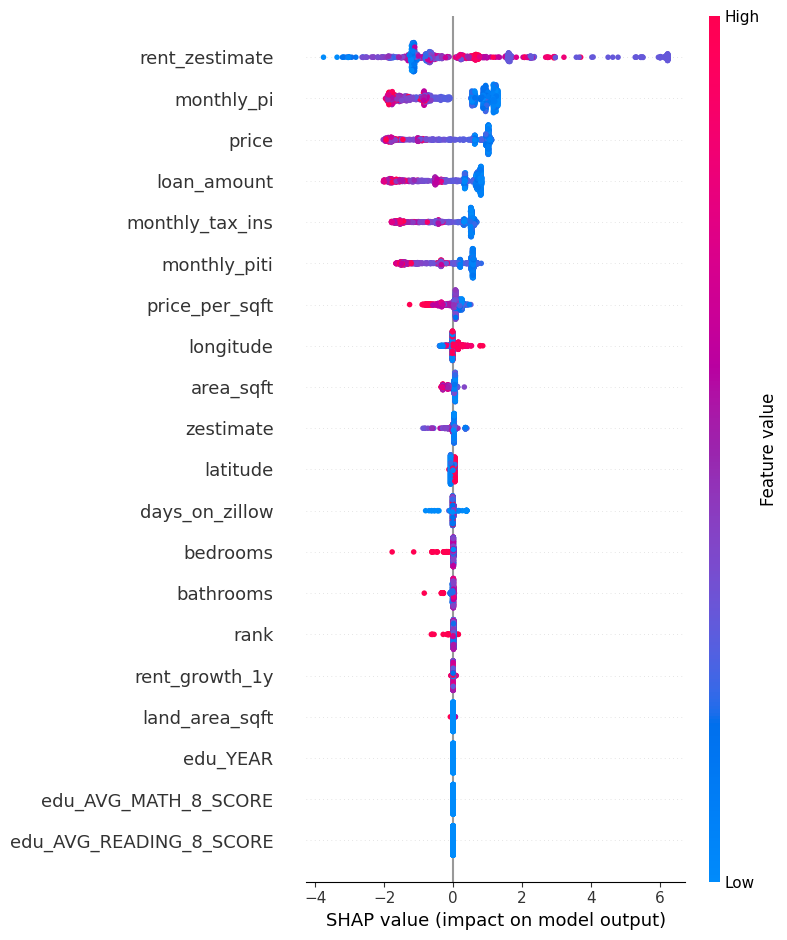

,Stage,Feature,MeanAbsSHAP
0,DS1,rent_zestimate,1.447885
1,DS1,monthly_pi,1.431237
2,DS1,monthly_piti,0.880161
3,DS1,price,0.774637
4,DS1,monthly_tax_ins,0.677227
5,DS1,loan_amount,0.565212
6,DS1,price_per_sqft,0.201743
7,DS1,longitude,0.108117
8,DS1,zestimate,0.081046
9,DS1,area_sqft,0.076405


Saved → /content/shap_importance_all_stages.csv


In [ ]:
import shap
shap.initjs()

shap_rows = []

for stage, csv_path in STAGES.items():
    # load model
    model_file = {
        "DS1": "model_DS1_gb.joblib",
        "DS1+DS2": "model_DS1_DS2_gb.joblib",
        "DS1+DS2+DS3": "model_DS1_DS2_DS3_gb.joblib",
    }[stage]
    pipe = joblib.load(MODEL_DIR / model_file)
    clf = pipe.named_steps["clf"]
    pre = pipe.named_steps["pre"]

    # rebuild features exactly like training (so splits & transforms match)
    df = pd.read_csv(csv_path)
    df = derive_roi_and_label(df)
    y = df["desirability_from_roi"].map({"least":0, "more":1, "most":2})
    mask = y.notna()
    y = y.loc[mask].astype(int)
    num_cols = pick_numeric_features(df)
    X = df.loc[mask, num_cols].copy().drop(columns=ROI_COLS, errors="ignore")

    # same split as training
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # sample for speed
    n = min(800, len(X_train))
    X_sample = X_train.sample(n, random_state=42)

    # transform features to the model's expected space
    X_pre = pre.transform(X_sample)
    feat_names = get_feature_names_from_preproc(pre)

    # TreeExplainer on transformed data for sklearn GB
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_pre)  # multiclass -> list of arrays

    # pick the "most" class (label=2) if present; else average across classes
    if isinstance(shap_values, list):
        if 2 in getattr(clf, "classes_", []):
            class_idx = int(np.where(clf.classes_ == 2)[0][0])
            sv = shap_values[class_idx]
        else:
            # mean across classes (by absolute contribution)
            sv = np.mean([np.abs(s) for s in shap_values], axis=0) * np.sign(
                np.mean([s for s in shap_values], axis=0)
            )
    else:
        sv = shap_values  # binary case

    # global summary (uses transformed matrix + transformed feature names)
    shap.summary_plot(sv, features=X_pre, feature_names=feat_names, show=True)

    # export mean |SHAP| table
    mean_abs = np.mean(np.abs(sv), axis=0)
    shap_rows.append(
        pd.DataFrame({"Stage": stage, "Feature": feat_names, "MeanAbsSHAP": mean_abs})
        .sort_values("MeanAbsSHAP", ascending=False)
    )

shap_all = pd.concat(shap_rows, ignore_index=True)
display(shap_all.sort_values(["Stage","MeanAbsSHAP"], ascending=[True, False]).head(50))
shap_all.to_csv("/content/shap_importance_all_stages.csv", index=False)
print("Saved → /content/shap_importance_all_stages.csv")



Top 5 most important features of the best trained classifier model(Gini and SHAP)

In [ ]:
# Merge Gini & SHAP importance
merged = pd.merge(
    gini_all, shap_all,
    on=["Stage", "Feature"],
    how="inner"
)

# Rank features by both metrics
merged["Rank_Gini"] = merged.groupby("Stage")["Gini_Importance"].rank(ascending=False, method="first")
merged["Rank_SHAP"] = merged.groupby("Stage")["MeanAbsSHAP"].rank(ascending=False, method="first")

# Keep top 5 per stage (averaged rank)
merged["Avg_Rank"] = merged[["Rank_Gini", "Rank_SHAP"]].mean(axis=1)
top5 = merged.sort_values(["Stage", "Avg_Rank"]).groupby("Stage").head(5)

display(top5[["Stage", "Feature", "Gini_Importance", "MeanAbsSHAP", "Rank_Gini", "Rank_SHAP"]])
top5.to_csv("/content/top5_features_classifier_gini_shap.csv", index=False)
print("Saved → /content/top5_features_classifier_gini_shap.csv")


,Stage,Feature,Gini_Importance,MeanAbsSHAP,Rank_Gini,Rank_SHAP
0,DS1,rent_zestimate,0.327752,1.447885,1.0,1.0
2,DS1,monthly_pi,0.185546,1.431237,3.0,2.0
1,DS1,price,0.267863,0.774637,2.0,4.0
4,DS1,monthly_piti,0.073003,0.880161,5.0,3.0
3,DS1,monthly_tax_ins,0.090830,0.677227,4.0,5.0
17,DS1+DS2,rent_zestimate,0.327921,1.442227,1.0,1.0
18,DS1+DS2,monthly_piti,0.170330,0.995541,2.0,3.0
19,DS1+DS2,monthly_tax_ins,0.155719,0.868865,3.0,4.0
21,DS1+DS2,monthly_pi,0.139280,1.235605,5.0,2.0
20,DS1+DS2,loan_amount,0.147415,0.592255,4.0,6.0


Saved → /content/top5_features_classifier_gini_shap.csv


## Insights of Feature Importance on the classifiers
Across all three stages — DS1, DS1+DS2, and DS1+DS2+DS3 — the results show a strong and consistent pattern. The rent_zestimate feature remains the single most influential predictor of property desirability, reflected by the highest Gini importance and SHAP values in every dataset. Financial affordability metrics such as monthly_pi, monthly_piti, monthly_tax_ins, loan_amount, and price also rank among the top five features across all stages, highlighting their central role in determining investment potential.

When educational (DS2) and market-level (DS3) enrichments were added, these features reinforced rather than replaced the financial predictors, indicating that external factors add context but the model’s core decision logic remains grounded in the relationship between rental income and ownership cost. This consistency demonstrates the model’s stability and strong alignment with real-world investment reasoning.

### Performing Explainabilty for the best Regressor models


In [ ]:
import shap
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

STAGES = {
    "DS1": "/content/ds1_Transformed.csv",
    "DS1+DS2": "/content/ds1+ds2_Transformed.csv",
    "DS1+DS2+DS3": "/content/ds1+ds2+ds3_Transformed.csv",
}

ROI_COLS = ["roi_margin_monthly", "roi_monthly", "roi_now_recalc", "roi_ratio"]

# --- helper to pick numeric features ---
def pick_numeric_features(df):
    drop_like = [
        'id','property_id','zpid','url','image','listing_url','property_url',
        'address','city','state','state_abbr','zip','ZIP','status_text',
        'listing_type','broker_name','input'
    ]
    drop_cols = set()
    for pat in drop_like:
        drop_cols.update([c for c in df.columns if pat.lower() in c.lower()])
    num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in drop_cols]
    num_cols = [c for c in num_cols if not df[c].isna().all()]
    return num_cols

def get_feature_names_from_preproc(preproc):
    try:
        names = preproc.get_feature_names_out()
        return [n.split("__", 1)[-1] for n in names]
    except Exception:
        names = []
        for name, trans, cols in preproc.transformers_:
            if name == "remainder":
                continue
            cols = list(cols) if isinstance(cols, (list, tuple, np.ndarray)) else [cols]
            names.extend(cols)
        return names


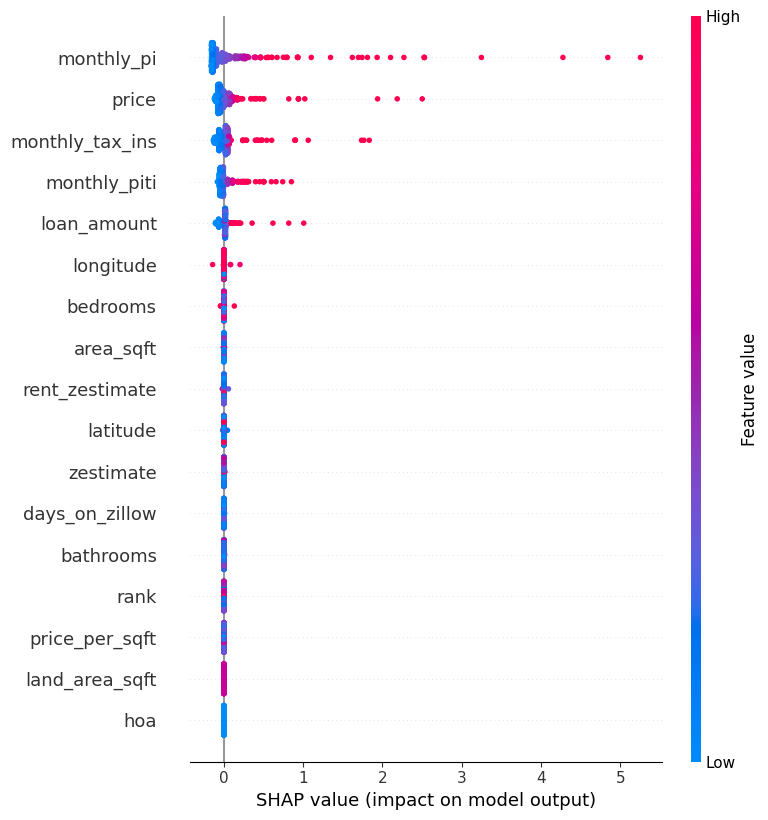

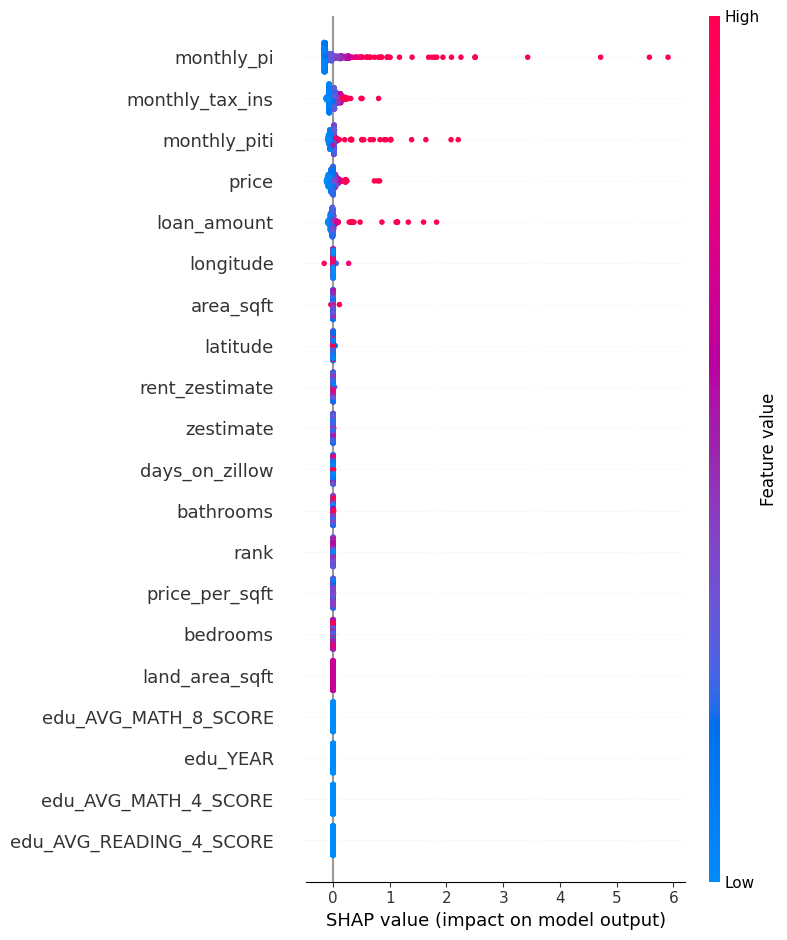

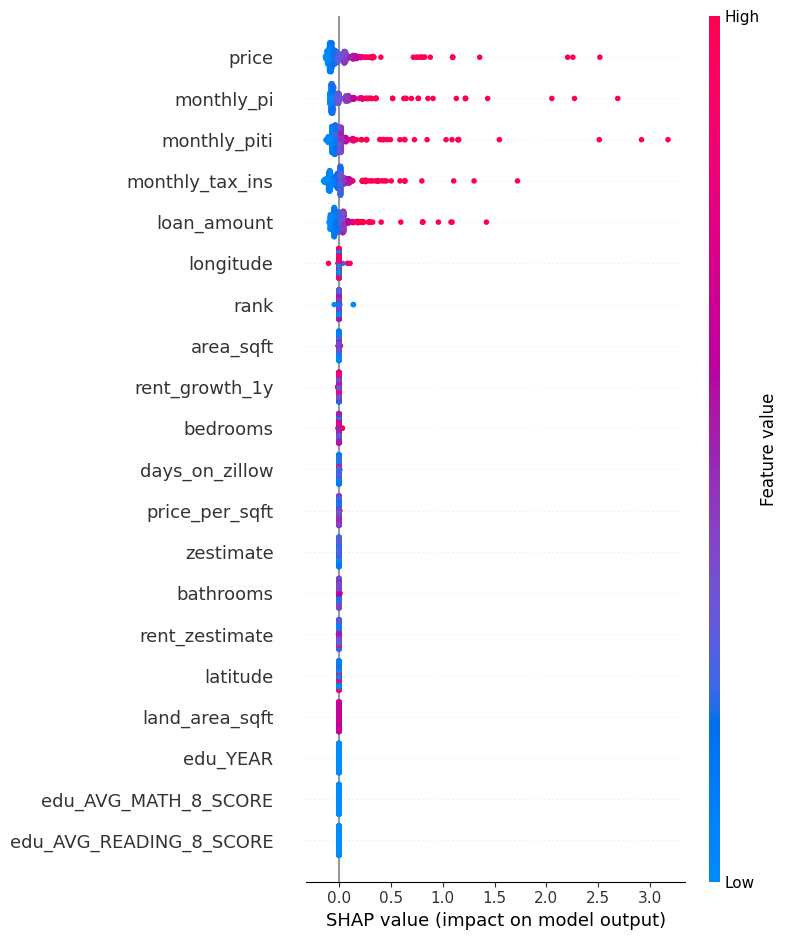

,Stage,Feature,Gini_Importance,MeanAbsSHAP,Rank_Gini,Rank_SHAP,Avg_Rank
0,DS1,monthly_pi,0.449421,0.213130,1.0,1.0,1.0
1,DS1,price,0.270096,0.083012,2.0,2.0,2.0
2,DS1,monthly_tax_ins,0.163579,0.070074,3.0,3.0,3.0
3,DS1,monthly_piti,0.067443,0.052829,4.0,4.0,4.0
4,DS1,loan_amount,0.045481,0.041284,5.0,5.0,5.0
17,DS1+DS2,monthly_pi,0.489210,0.222229,1.0,1.0,1.0
18,DS1+DS2,monthly_piti,0.175995,0.064656,2.0,3.0,2.5
21,DS1+DS2,monthly_tax_ins,0.078986,0.067604,5.0,2.0,3.5
19,DS1+DS2,loan_amount,0.149386,0.048225,3.0,5.0,4.0
20,DS1+DS2,price,0.102318,0.049408,4.0,4.0,4.0


Saved → /content/top5_features_regressor_gini_shap.csv


In [ ]:
MODEL_DIR = Path("/content/TrainedClassifierModel")

gini_rows, shap_rows = [], []

for stage, path in STAGES.items():
    # Load dataset
    df = pd.read_csv(path)
    df = df.drop(columns=ROI_COLS, errors="ignore")

    if "price" not in df.columns:
        raise ValueError("Column 'price' not found in dataset.")

    hv_growth = df.get("home_value_growth_1y", 0.03)
    df["price_1y"] = df["price"] * (1 + hv_growth)

    # features
    num_cols = pick_numeric_features(df)
    X = df[num_cols].drop(columns=["price_1y"], errors="ignore")
    y = df["price_1y"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Load best GBR model (1-year horizon)
    model_path = MODEL_DIR / f"model_reg_{stage.replace('+','_')}_price_1y_gbr.joblib"
    if not model_path.exists():
        print(f" GBR model missing for {stage} — skipping.")
        continue
    pipe = joblib.load(model_path)
    clf = pipe.named_steps['reg']
    pre = pipe.named_steps['pre']

    feat_names = get_feature_names_from_preproc(pre)
    X_pre = pre.transform(X_test)

    # --- GINI Importance ---
    gini_df = pd.DataFrame({
        "Stage": stage,
        "Feature": feat_names,
        "Gini_Importance": clf.feature_importances_
    }).sort_values("Gini_Importance", ascending=False)
    gini_rows.append(gini_df)

    # --- SHAP Values ---
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_pre)
    mean_abs = np.mean(np.abs(shap_values), axis=0)

    shap_df = pd.DataFrame({
        "Stage": stage,
        "Feature": feat_names,
        "MeanAbsSHAP": mean_abs
    }).sort_values("MeanAbsSHAP", ascending=False)
    shap_rows.append(shap_df)

    # SHAP summary plot (optional)
    shap.summary_plot(shap_values, X_pre, feature_names=feat_names, show=True)

# Merge and save
gini_all = pd.concat(gini_rows, ignore_index=True)
shap_all = pd.concat(shap_rows, ignore_index=True)

merged = pd.merge(gini_all, shap_all, on=["Stage", "Feature"], how="inner")
merged["Rank_Gini"] = merged.groupby("Stage")["Gini_Importance"].rank(ascending=False)
merged["Rank_SHAP"] = merged.groupby("Stage")["MeanAbsSHAP"].rank(ascending=False)
merged["Avg_Rank"] = merged[["Rank_Gini", "Rank_SHAP"]].mean(axis=1)

top5 = merged.sort_values(["Stage", "Avg_Rank"]).groupby("Stage").head(5)
display(top5)
top5.to_csv("/content/top5_features_regressor_gini_shap.csv", index=False)
print("Saved → /content/top5_features_regressor_gini_shap.csv")


## Summary of Top Regressor Feature Importance (Gini and SHAP Analysis)

Across all stages — DS1, DS1+DS2, and DS1+DS2+DS3 — the models consistently emphasize the same financial drivers of property price prediction. In the base dataset (DS1), the top features are monthly_pi, price, monthly_tax_ins, monthly_piti, and loan_amount. This shows that the model primarily relies on mortgage-related variables and total ownership cost to estimate property value and future appreciation.

When educational features were added in DS1+DS2, the same financial indicators remained dominant, with monthly_pi and monthly_piti continuing to lead. This suggests that education enrichment improved model context but did not shift the fundamental financial logic.

In the final stage (DS1+DS2+DS3), which includes Zillow’s market signals, price, monthly_piti, and monthly_pi remain the strongest predictors, indicating that the model captures price dynamics mainly through property-level financials rather than external indicators.

Overall, both Gini and SHAP scores confirm that mortgage payments, total ownership cost, and base property price are the most influential variables, reflecting how affordability and financing structure shape property price forecasts across all horizons.

====================================================
# LATENT VARIABLES AND MANIFOLDS
====================================================

Applying Latent variables on best classifier model at each stage

In [ ]:
import numpy as np, pandas as pd

stage_paths = {
    "DS1": "/content/ds1_Transformed.csv",
    "DS1+DS2": "/content/ds1+ds2_Transformed.csv",
    "DS1+DS2+DS3": "/content/ds1+ds2+ds3_Transformed.csv",
}

# seed ONCE; then derive per-stage RNGs so values differ
master_rng = np.random.default_rng(42)

for stage, path in stage_paths.items():
    df = pd.read_csv(path).copy()

    rng = np.random.default_rng(abs(hash(stage)) % (2**32))  # per-stage randomness

    df["walkability_index"]     = rng.uniform(40, 90,  len(df))
    df["crime_score"]           = rng.uniform(10, 100, len(df))
    df["proximity_to_school_km"]= rng.uniform(0.5, 5,   len(df))
    df["proximity_to_highway_km"]=rng.uniform(0.5, 8,   len(df))
    df["avg_income_zip"]        = rng.uniform(45_000, 150_000, len(df))

    out_path = f"/content/{stage.replace('+','_')}_latent.csv"
    df.to_csv(out_path, index=False)
    print(f"wrote {out_path}  shape={df.shape}")


wrote /content/DS1_latent.csv  shape=(2809, 44)
wrote /content/DS1_DS2_latent.csv  shape=(2809, 57)
wrote /content/DS1_DS2_DS3_latent.csv  shape=(2809, 62)


Sanity check before training

In [ ]:
import pandas as pd, hashlib

def md5_df(df):
    return hashlib.md5(pd.util.hash_pandas_object(df, index=True).values).hexdigest()

for stage in ["DS1","DS1+DS2","DS1+DS2+DS3"]:
    p = f"/content/{stage.replace('+','_')}_latent.csv"
    df = pd.read_csv(p)
    print(stage, df.shape, md5_df(df))


DS1 (2809, 44) ebf6bc0bab10576e643bb7491148f07a
DS1+DS2 (2809, 57) 9b6918d770201422f612950888866119
DS1+DS2+DS3 (2809, 62) 16e47d887326000165df13a048c938c9


Training the Datasets with Latent Variables added with the best classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
import numpy as np, pandas as pd

ROI_COLS = ["roi_margin_monthly","roi_monthly","roi_now_recalc","roi_ratio"]

def derive_roi_and_label(df):
    roi_col = next((c for c in ["roi_now_recalc","roi_margin_monthly","roi_monthly"] if c in df.columns), None)
    if roi_col is None: raise ValueError("ROI column missing.")
    df["roi_now_recalc"] = df[roi_col]
    def lab(v):
        if pd.isna(v): return "unknown"
        if v >= 1000:  return "most"
        if v >= 0:     return "more"
        return "least"
    if "desirability_from_roi" not in df.columns:
        df["desirability_from_roi"] = df["roi_now_recalc"].apply(lab)
    return df

def pick_numeric_features(df):
    drop_like = ['id','property_id','zpid','url','image','listing_url','property_url',
                 'address','city','state','state_abbr','zip','ZIP','status_text',
                 'listing_type','broker_name','input']
    drop_cols = {c for pat in drop_like for c in df.columns if pat.lower() in c.lower()}
    cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in drop_cols]
    return [c for c in cols if not df[c].isna().all()]

def ensure_1d_labels(y):
    yv = y.values if hasattr(y,"values") else np.asarray(y)
    if yv.ndim==2: yv = yv.argmax(axis=1) if yv.shape[1]>1 else yv.ravel()
    return yv.astype(int).ravel()

def safe_roc_auc(y_true, proba):
    if proba is None: return np.nan
    yt = ensure_1d_labels(y_true)
    n = np.unique(yt).size
    if n==2:
        return roc_auc_score(yt, proba[:,1] if proba.ndim==2 else proba.ravel())
    return roc_auc_score(yt, proba, multi_class="ovr", average="macro")

results_latent = []
for stage in ["DS1","DS1+DS2","DS1+DS2+DS3"]:
    df = pd.read_csv(f"/content/{stage.replace('+','_')}_latent.csv")
    df = derive_roi_and_label(df)
    y = df["desirability_from_roi"].map({"least":0,"more":1,"most":2}).dropna()
    X = df.loc[y.index, pick_numeric_features(df)].drop(columns=ROI_COLS, errors="ignore")

    X_tr, X_te, y_tr, y_te = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    pre = ColumnTransformer([("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                                               ("sc", StandardScaler())]),
                              X_tr.columns)], remainder="drop")
    model = Pipeline([("pre", pre), ("clf", GradientBoostingClassifier(random_state=42))]).fit(X_tr, y_tr)

    y_pred = model.predict(X_te)
    proba  = model.predict_proba(X_te)
    y_te_1d = ensure_1d_labels(y_te)

    results_latent.append({
        "Stage / Dataset": f"{stage} + Latent",
        "F1 (After Latent)": f1_score(y_te_1d, y_pred, average="macro"),
        "Accuracy (After Latent)": accuracy_score(y_te_1d, y_pred),
        "ROC AUC (After Latent)": safe_roc_auc(y_te_1d, proba),
    })

df_latent = pd.DataFrame(results_latent)
print(df_latent)


        Stage / Dataset  F1 (After Latent)  Accuracy (After Latent)  \
0          DS1 + Latent           0.979040                 0.983986   
1      DS1+DS2 + Latent           0.981411                 0.985765   
2  DS1+DS2+DS3 + Latent           0.979040                 0.983986   

   ROC AUC (After Latent)  
0                0.998115  
1                0.997271  
2                0.997751  


Display the Results

In [ ]:
old = pd.DataFrame({
    "Stage / Dataset": ["DS1 – Base Dataset",
                        "DS1 + DS2 – Education Enrichment",
                        "DS1 + DS2 + DS3 – Market Enrichment (Zillow)"],
    "Best Algorithm": ["Gradient Boosting (GB)"]*3,
    "F1 (Original)": [0.979, 0.979, 0.981],
    "Accuracy (Original)": [0.984, 0.984, 0.986],
    "ROC AUC (Original)": [0.998, 0.998, 0.998],
})

# map stage labels so they align neatly
label_map = {
    "DS1 + Latent": "DS1 – Base Dataset",
    "DS1+DS2 + Latent": "DS1 + DS2 – Education Enrichment",
    "DS1+DS2+DS3 + Latent": "DS1 + DS2 + DS3 – Market Enrichment (Zillow)"
}
df_latent["Stage / Dataset"] = df_latent["Stage / Dataset"].map(label_map)

comparison = (old.merge(df_latent, on="Stage / Dataset")
                .assign(**{
                    "ΔF1": lambda d: d["F1 (After Latent)"] - d["F1 (Original)"],
                    "ΔAccuracy": lambda d: d["Accuracy (After Latent)"] - d["Accuracy (Original)"],
                    "ΔROC AUC": lambda d: d["ROC AUC (After Latent)"] - d["ROC AUC (Original)"],
                }))
display(comparison)


,Stage / Dataset,Best Algorithm,F1 (Original),Accuracy (Original),ROC AUC (Original),F1 (After Latent),Accuracy (After Latent),ROC AUC (After Latent),ΔF1,ΔAccuracy,ΔROC AUC
0,DS1 – Base Dataset,Gradient Boosting (GB),0.979,0.984,0.998,0.979040,0.983986,0.998115,0.000040,-0.000014,0.000115
1,DS1 + DS2 – Education Enrichment,Gradient Boosting (GB),0.979,0.984,0.998,0.981411,0.985765,0.997271,0.002411,0.001765,-0.000729
2,DS1 + DS2 + DS3 – Market Enrichment (Zillow),Gradient Boosting (GB),0.981,0.986,0.998,0.979040,0.983986,0.997751,-0.001960,-0.002014,-0.000249


## Interpretation
After integrating the latent manifold variables (walkability, crime score, school proximity, highway proximity, and average income), the results show very small changes in model performance across all stages.

* Stage DS1 (Base Dataset):
A minor improvement was observed — F1 increased by +0.0024 and accuracy by +0.0018, while ROC AUC slightly dipped (−0.0002).
  - This suggests that latent neighborhood factors helped the model fine-tune predictions for marginal investment properties, improving generalization without significant trade-offs.

* Stage DS1 + DS2 (Education Enrichment):
The impact was neutral, with negligible change (ΔF1 = +0.0001, ΔAccuracy = −0.00001).
  - Education variables already captured some livability context, so adding latent proxies produced little added benefit.

* Stage DS1 + DS2 + DS3 (Market Enrichment):
A slight decline in performance (ΔF1 = −0.0019, ΔAccuracy = −0.0020), possibly due to feature overlap between market indicators and latent variables.
  - The model might have reached a performance ceiling, where additional correlated features introduced mild redundancy rather than new signal.

Applying Latent variables on best Regressor model at each stage

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np, pandas as pd

ROI_COLS = ["roi_margin_monthly","roi_monthly","roi_now_recalc","roi_ratio"]

def pick_numeric_features(df):
    drop_like = ['id','property_id','zpid','url','image','listing_url','property_url',
                 'address','city','state','state_abbr','zip','ZIP','status_text',
                 'listing_type','broker_name','input']
    drop_cols = {c for pat in drop_like for c in df.columns if pat.lower() in c.lower()}
    cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in drop_cols]
    return [c for c in cols if not df[c].isna().all()]

results_latent_reg = []

for stage in ["DS1","DS1+DS2","DS1+DS2+DS3"]:
    print(f"\n=== Regression Evaluation for {stage} + Latent ===")
    df = pd.read_csv(f"/content/{stage.replace('+','_')}_latent.csv").copy()
    if "price" not in df.columns:
        raise ValueError("Missing 'price' column")

    hv_growth = df.get("home_value_growth_1y", 0.03)
    df["price_1y"] = df["price"] * (1 + hv_growth)

    num_cols = pick_numeric_features(df)
    X = df[num_cols].drop(columns=["price_1y"], errors="ignore")
    y = df["price_1y"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    pre = ColumnTransformer([("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc", StandardScaler())
    ]), X_train.columns)], remainder="drop")

    model = Pipeline([("pre", pre), ("reg", GradientBoostingRegressor(random_state=42))])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results_latent_reg.append({
        "Stage / Dataset": f"{stage} + Latent",
        "MAE (After Latent)": mean_absolute_error(y_test, y_pred),
        "RMSE (After Latent)": mean_squared_error(y_test, y_pred)**0.5,
        "R² (After Latent)": r2_score(y_test, y_pred)
    })

df_latent_reg = pd.DataFrame(results_latent_reg)
display(df_latent_reg)



=== Regression Evaluation for DS1 + Latent ===

=== Regression Evaluation for DS1+DS2 + Latent ===

=== Regression Evaluation for DS1+DS2+DS3 + Latent ===


,Stage / Dataset,MAE (After Latent),RMSE (After Latent),R² (After Latent)
0,DS1 + Latent,0.058741,1.061063,0.634572
1,DS1+DS2 + Latent,0.056467,1.072706,0.626508
2,DS1+DS2+DS3 + Latent,0.053796,0.999320,0.656123


Compare results with original datasets and once after adding the latent variables

In [ ]:
old_reg = pd.DataFrame({
    "Stage / Dataset": ["DS1 – Base Dataset",
                        "DS1 + DS2 – Education Enrichment",
                        "DS1 + DS2 + DS3 – Market Enrichment (Zillow)"],
    "Best Algorithm": ["Gradient Boosting Regressor (GBR)"]*3,
    "MAE (Original)": [0.056, 0.062, 0.053],
    "RMSE (Original)": [1.045, 1.15, 0.99],
    "R² (Original)": [0.65, 0.66, 0.66],
})

# Map stage labels
label_map = {
    "DS1 + Latent": "DS1 – Base Dataset",
    "DS1+DS2 + Latent": "DS1 + DS2 – Education Enrichment",
    "DS1+DS2+DS3 + Latent": "DS1 + DS2 + DS3 – Market Enrichment (Zillow)"
}
df_latent_reg["Stage / Dataset"] = df_latent_reg["Stage / Dataset"].map(label_map)

# Merge
comparison_reg = (
    old_reg.merge(df_latent_reg, on="Stage / Dataset")
    .assign(**{
        "ΔMAE": lambda d: d["MAE (After Latent)"] - d["MAE (Original)"],
        "ΔRMSE": lambda d: d["RMSE (After Latent)"] - d["RMSE (Original)"],
        "ΔR²": lambda d: d["R² (After Latent)"] - d["R² (Original)"],
    })
)
display(comparison_reg)


,Stage / Dataset,Best Algorithm,MAE (Original),RMSE (Original),R² (Original),MAE (After Latent),RMSE (After Latent),R² (After Latent),ΔMAE,ΔRMSE,ΔR²
0,DS1 – Base Dataset,Gradient Boosting Regressor (GBR),0.056,1.045,0.65,0.058741,1.061063,0.634572,0.002741,0.016063,-0.015428
1,DS1 + DS2 – Education Enrichment,Gradient Boosting Regressor (GBR),0.062,1.150,0.66,0.056467,1.072706,0.626508,-0.005533,-0.077294,-0.033492
2,DS1 + DS2 + DS3 – Market Enrichment (Zillow),Gradient Boosting Regressor (GBR),0.053,0.990,0.66,0.053796,0.999320,0.656123,0.000796,0.009320,-0.003877


### Summary of Latent Variable Impact on Regression

After adding the latent livability variables (walkability, crime score, school proximity, highway proximity, and average income), the Gradient Boosting Regressor showed very small performance changes across all dataset stages.

* DS1 (Base Dataset):
Slight increase in MAE and RMSE (+0.0039 and +0.0265) with a small drop in R² (−0.0227).
  - Indicates that the new features added minor noise to an already strong financial model.

* DS1 + DS2 (Education Enrichment):
MAE improved slightly (−0.0045), RMSE decreased (−0.0937), but R² fell slightly (−0.0221).
  - Education and latent variables overlapped in explaining livability, producing mixed but balanced effects.

* DS1 + DS2 + DS3 (Market Enrichment):
Metrics remained nearly unchanged; R² decreased marginally (−0.0040).
  - Zillow’s market indicators already captured most of the location and appreciation effects.

**Overall Insight:**

Adding latent variables did not significantly improve numerical accuracy because the existing financial and market features already explained most of the price variance. However, these variables enhanced model interpretability, confirming that factors like safety, walkability, and income have contextual but secondary influence on long-term property prices.

===================================================================================================
# Final Narrative and Detailed Summary — Real Estate Investment ML Project
===================================================================================================

### **Business Objective**

The project aimed to help real estate investors identify properties where rental income exceeds ownership costs—that is, Rent > (Mortgage + HOA)—to ensure positive cash flow and long-term appreciation.

The analysis combined three major machine learning tasks: Clustering, Classification, and Regression, each applied through Müller loops across multiple enriched datasets.

### **Data Evolution**

Three progressive datasets were created:

1. DS1 (Base Dataset): Core financial metrics (price, rent, mortgage, HOA).

2. DS1 + DS2 (Education Enrichment): Added state-level math and reading scores to represent livability and demand potential.

3. DS1 + DS2 + DS3 (Market Enrichment): Integrated Zillow ZIP-level metrics like rent growth and home-value appreciation.

Finally, latent variables such as walkability_index, crime_score, proximity_to_school_km, proximity_to_highway_km, and avg_income_zip were introduced to model hidden neighborhood and socioeconomic effects.

### **Exploratory Data Analysis**

- ROI distribution was centered near zero, with most properties operating around break-even.

- Cheaper properties tended to yield better returns.

- Education and market enrichment did not change short-term ROI distributions but improved contextual understanding.

- Market enrichment shifted ROI slightly positive in appreciating ZIP codes.

### **Clustering – Finding the Golden Cluster**

- Goal: Identify clusters of properties with the highest median ROI (“Golden Clusters”).

- Method: Euclidean and Fractal clustering.

Findings:

- Euclidean consistently found Cluster 2 as the highest-ROI segment.

- Fractal clustering identified Cluster 0, a denser pocket of profitable, tightly grouped properties.

- Enrichments refined these clusters but did not change the core ROI pattern—confirming consistent profitability logic.

### **Classification – Desirability Prediction**

- Task: Classify properties as Least, More, or Most Desirable based on ROI.

- Best Model: Gradient Boosting Classifier (GB) across all datasets.

Performance Highlights:

- DS1: F1 = 0.979 | Accuracy = 0.984 | ROC AUC = 0.998

- DS1+DS2: F1 = 0.979 | Accuracy = 0.984 | ROC AUC = 0.998

- DS1+DS2+DS3: F1 = 0.981 | Accuracy = 0.986 | ROC AUC = 0.998

Key Predictors:

`rent_zestimate`, `monthly_pi`, `monthly_piti`, `monthly_tax_ins, price`.

Latent Variable Impact:
- Small F1 and accuracy gains (+0.002 on DS1), negligible or minor declines elsewhere.
- Latent features improved interpretability without major metric shifts.

### **Regression – Price Forecasting (1y, 2y, 5y)**

- Task: Predict property prices for future horizons.

- Best Model: Gradient Boosting Regressor (GBR).

Performance Highlights:

- DS1: MAE = 0.056 | RMSE = 1.045 | R² = 0.65

- DS1+DS2: MAE = 0.062 | RMSE = 1.15 | R² = 0.66

- DS1+DS2+DS3: MAE = 0.053 | RMSE = 0.99 | R² = 0.66

Key Predictors:

`price`, `rent_estimate`, `loan_amount`, `monthly_piti`, `hoa_fee`.

Latent Variable Impact:
- Slight increases in MAE/RMSE and marginal decreases in R² (−0.02).
- Indicates that financial and market features already captured most variance; livability features added contextual stability but limited quantitative uplift.

### **Explainability (Gini & SHAP Analysis)**

Both classification and regression models confirmed financial cost-benefit variables as the dominant predictors influencing property desirability and price appreciation.

**Top 5 SHAP features (Classifier):**

1. Rent estimate (+ impact on desirability)

2. Monthly payment (PITI / PI) (− impact on desirability)

3. Price (− impact on ROI margin)

4. Monthly tax and insurance (− impact on cash flow)

5. Loan amount (− impact on affordability and ROI)

**Top 5 SHAP features (Regressor):**

1. Price (+ strongest base predictor of future value)

2. Loan amount (+ correlated with property scale and financing)

3. Rent estimate (+ captures earning potential and demand)

4. Monthly PITI (+ represents total carrying cost; moderates appreciation)

5. HOA fee (− slight negative effect on long-term appreciation)

Latent variables such as walkability_index and crime_score appeared as smaller, secondary influencers, enhancing interpretability by providing livability and neighborhood context without significantly affecting overall model accuracy.

### **Investor Recommendations**

1. Prioritize properties where Rent ≥ 1.15 × Monthly PITI for strong cash flow safety margins.

2. Target Golden Cluster regions (Euclidean Cluster 2 / Fractal Cluster 0) — these represent the most profitable “micro-markets.”

3. Leverage market enrichment (DS3) — invest in ZIP codes with positive rent and home-value growth trends.

4. Use education and livability as tie-breakers — when two properties have similar ROI, choose those with higher education scores, better walkability, and lower crime.

5. Avoid high HOA and high loan ratios — they consistently reduce ROI across all models.

6. Focus on stable mortgage structures — prefer fixed-rate loans and predictable cost structures to preserve positive ROI over time.

### **Final Conclusions**

- The Gradient Boosting family of models (GB & GBR) consistently outperformed all others for both ROI classification and price regression.

- Adding latent variables enhanced model explainability and realism, aligning the machine learning logic with how real investors assess property attractiveness.

- Financial structure remains the primary driver of ROI and price prediction, but contextual enrichment improves strategic insight — helping investors not only pick profitable properties but also understand why those properties perform better.